**Deskripsi**

Proyek ini menggunakan dua kumpulan data demand hotel di Portugal. Kedua hotel tersebut adalah **Resort Hotel** dan **City Hotel**. Adapun jumlah data yang akan diolah adalah **32 variabel** dan **119390 pemesanan hotel**. Pemesanan yang terdaftar yaitu dari **1 Juli 2015 s/d 31 Agustus 2017** termasuk pelanggan yang membatalkan pemesanan. Data ini merupakan real data, sehingga elemen yang berkaitan dengan hotel dan pelanggan disamarkan/dihapus.

**Masalah**

Banyaknya pemesanan hotel yang dibatalkan.

**Goals**

- Memprediksi model terbaik untuk pelanggan yang akan membatalkan pemesanan.
- Memberikan rekomendasi bisnis terkait hal tersebut.
- Memberikan bussiness insight terkait data tersebut.

**Sumber**

- Dataset : https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand
- Articles : Antonio, N., de Almeida, A., & Nunes, L. (2019). Hotel booking demand datasets. Data in brief, 22, 41-49.

**Feature and Target**

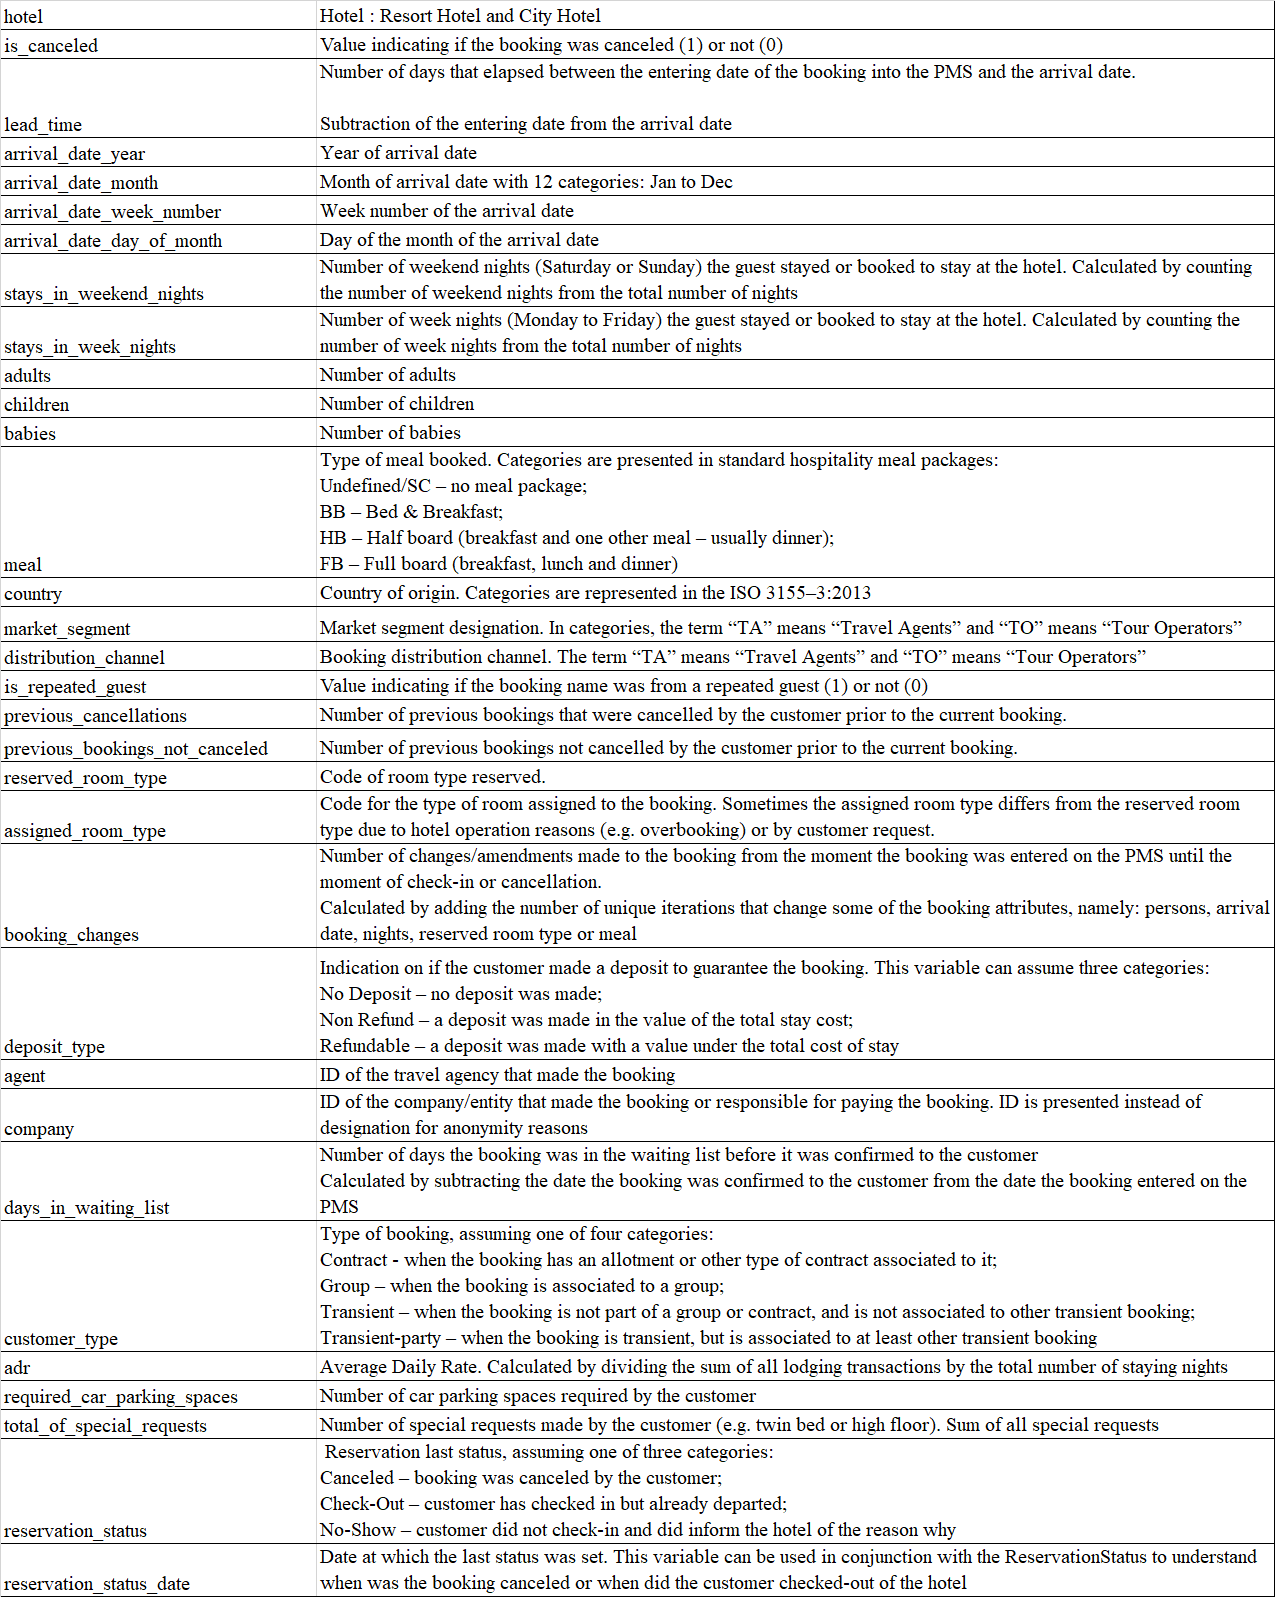

# Import Data & Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#EDA
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

#Preprocessing
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn import under_sampling, over_sampling

#Metric Evaluation
from sklearn.metrics import accuracy_score, recall_score, precision_score,confusion_matrix, roc_auc_score, f1_score
from sklearn import metrics

#Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

#Intrepretation Model
!pip install dalex
import dalex as dx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data Scientist/Course Dibimbing.id/Assignment/hotel_bookings.csv')

In [ ]:
#for viewing All 32 columns of Dataframe
pd.set_option('display.max_columns', None)

# Basic Information

In [ ]:
df.shape

(119390, 32)

**Intrepretation** :
- Ada 119390 pemesanan hotel termasuk pembatalan pemesanan tercatat.

In [ ]:
df.sample(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
58727,City Hotel,1,93,2016,October,42,15,2,1,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,34.0,NaN,0,Transient,115.0,0,0,Canceled,2016-08-11
33865,Resort Hotel,0,7,2017,March,9,2,1,3,2,0.0,0,BB,NLD,Groups,Corporate,0,0,0,A,A,0,No Deposit,NaN,223.0,0,Transient-Party,37.0,0,0,Check-Out,2017-03-06
44358,City Hotel,0,61,2015,October,41,4,2,0,2,0.0,0,BB,FRA,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,12.0,NaN,0,Transient-Party,91.0,0,0,Check-Out,2015-10-06


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

**Observation** :
- Ada missing value.
- Ada beberapa tipe data yang mesti diubah untuk mempermudah EDA.
- `is_canceled` dapat menjadi target model.

#### Treatment : Data Type

In [ ]:
#Mengubah Tipe Data reservation_status_date
df["reservation_status_date"] = pd.to_datetime(df["reservation_status_date"],dayfirst=True)

`children`, `agent`, dan `company` akan diubah tipe nya setelah missing value diatasi.

# Data Cleaning

## Missing Values

In [ ]:
#Mengecek Adanya Missing Value
missing = pd.DataFrame({"Missing Value" : df.isnull().sum(), "% Missing Value" : df.isnull().sum()/len(df)*100})
missing[missing["Missing Value"]>0]

,Missing Value,% Missing Value
children,4,0.003350
country,488,0.408744
agent,16340,13.686238
company,112593,94.306893


**Observation** :
- `Children` dan `Country` memiliki missing value yang kurang dari 1%.
- `Children` hanya memiliki missing value yang minim, diasumsikan tidak memiliki anak.
- Karena terliat dibeberapa kolom ada data yang diisi dengan undefined, maka missing value pada `Country` akan diisi oleh undefined juga.
- Karena persentase missing value pada `Company` sangat besar, sehingga kolom akan di drop.
- Karena `agent` cukup banyak, data tersebut akan diisi dengan nilai lain.

### **Handling Missing Values**

#### **Treatment for Missing Values in Company Column**

In [ ]:
#menghapus kolom company
df.drop(columns="company",inplace=True)

#### **Treatment for Missing Values in Children Column**

In [ ]:
#Mengisi NaN menjadi 0 (diasumsikan tidak memiliki anak)
df["children"]=df["children"].fillna(0)

In [ ]:
#Merubah tipe data dari float menjadi int karena manusia pasti berjumlah sebanyak bilangan bulat

df['children'] = df['children'].astype(int)

#### **Treatment for Missing Values in Country Column**

In [ ]:
#Mengisi data NaN menjadi Undefined
df["country"]=df["country"].fillna("Undefined")

#### **Treatment for Missing Values in Agent Column**

<Axes: xlabel='agent'>

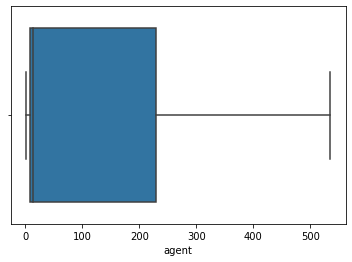

In [ ]:
#cek outlier
sns.boxplot(x=df["agent"],data=df)

Karena tidak ada outlier, maka missing values akan diisi dengan nilai mean

In [ ]:
#Mengisi NaN dengan mean yang dibulatkan (karena agent adalah ID tidak mungkin desimal)
df["agent"]=df["agent"].fillna(round(df["agent"].mean()))

In [ ]:
#Karena agent adalah ID, tidak mungkin desimal
df['agent'] = df['agent'].astype(int)

*Handling Missing Values DONE*

In [ ]:
df.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces 

## Another Cases

#### ADR >= 0
*   Nilai ADR tidak mungkin negatif, jadi data tersebut akan dihilangkan


In [ ]:
#Cek apakah kasus tersebut ada?
df[df["adr"]<0.0]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
14969,Resort Hotel,0,195,2017,March,10,5,4,6,2,0,0,BB,GBR,Groups,Direct,1,0,2,A,H,2,No Deposit,273,0,Transient-Party,-6.38,0,0,Check-Out,2017-03-15


Ternyata ada satu data yaitu index 14969

In [ ]:
#Menghapus data diatas
df = df[df["adr"]>=0.0]

#### Total Pengunjung > 0
*   Perlu ada minimal 1 orang yang menginap agar data valid. Selain itu, bayi pun tidak akan menginap sendiri tanpa orang tua atau kakaknya. Jadi akan dihilangkan data yang jumlah `adult` dan `children` adalah 0.

In [ ]:
#Cek apakah kasus tersebut ada?
df[(df["adults"]+df["children"])==0]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
2224,Resort Hotel,0,1,2015,October,41,6,0,3,0,0,0,SC,PRT,Corporate,Corporate,0,0,0,A,I,1,No Deposit,87,0,Transient-Party,0.00,0,0,Check-Out,2015-10-06
2409,Resort Hotel,0,0,2015,October,42,12,0,0,0,0,0,SC,PRT,Corporate,Corporate,0,0,0,A,I,0,No Deposit,87,0,Transient,0.00,0,0,Check-Out,2015-10-12
3181,Resort Hotel,0,36,2015,November,47,20,1,2,0,0,0,SC,ESP,Groups,TA/TO,0,0,0,A,C,0,No Deposit,38,0,Transient-Party,0.00,0,0,Check-Out,2015-11-23
3684,Resort Hotel,0,165,2015,December,53,30,1,4,0,0,0,SC,PRT,Groups,TA/TO,0,0,0,A,A,1,No Deposit,308,122,Transient-Party,0.00,0,0,Check-Out,2016-01-04
3708,Resort Hotel,0,165,2015,December,53,30,2,4,0,0,0,SC,PRT,Groups,TA/TO,0,0,0,A,C,1,No Deposit,308,122,Transient-Party,0.00,0,0,Check-Out,2016-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115029,City Hotel,0,107,2017,June,26,27,0,3,0,0,0,BB,CHE,Online TA,TA/TO,0,0,0,A,A,1,No Deposit,7,0,Transient,100.80,0,0,Check-Out,2017-06-30
115091,City Hotel,0,1,2017,June,26,30,0,1,0,0,0,SC,PRT,Complementary,Direct,0,0,0,E,K,0,No Deposit,87,0,Transient,0.00,1,1,Check-Out,2017-07-01
116251,City Hotel,0,44,2017,July,28,15,1,1,0,0,0,SC,SWE,Online TA,TA/TO,0,0,0,A,K,2,No Deposit,425,0,Transient,73.80,0,0,Check-Out,2017-07-17
116534,City Hotel,0,2,2017,July,28,15,2,5,0,0,0,SC,RUS,Online TA,TA/TO,0,0,0,A,K,1,No Deposit,9,0,Transient-Party,22.86,0,1,Check-Out,2017-07-22


Ternyata ada 180 data yang perlu di drop.

In [ ]:
#Menghapus data diatas
df = df[df["adults"]+df["children"]!=0]
df.shape

(119209, 31)

#### Total Stays > 0
*   Perlu minimal 1 hari untuk menginap agar data tersebut valid. Sehingga data yang jumlah `stays_in_weekend_nights` dan `stays_in_week_nights` nol akan di drop.

In [ ]:
#Cek apakah kasus tersebut ada?
df[(df["stays_in_weekend_nights"]+df["stays_in_week_nights"])==0]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,87,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,87,0,Transient,0.0,0,0,Check-Out,2015-07-01
167,Resort Hotel,0,111,2015,July,28,6,0,0,2,0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,H,0,No Deposit,240,0,Transient,0.0,0,2,Check-Out,2015-07-06
168,Resort Hotel,0,0,2015,July,28,6,0,0,1,0,0,BB,PRT,Direct,Direct,0,0,0,E,H,0,No Deposit,250,0,Transient,0.0,0,0,Check-Out,2015-07-06
196,Resort Hotel,0,8,2015,July,28,7,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,A,A,0,No Deposit,87,0,Transient,0.0,0,1,Check-Out,2015-07-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115483,City Hotel,0,15,2017,July,27,6,0,0,1,0,0,SC,FRA,Direct,Direct,0,0,0,A,A,0,No Deposit,14,0,Transient-Party,0.0,0,0,Check-Out,2017-07-06
117701,City Hotel,0,0,2017,August,32,8,0,0,2,0,0,BB,PRT,Offline TA/TO,TA/TO,1,0,0,A,A,0,No Deposit,262,0,Transient,0.0,0,0,Check-Out,2017-08-08
118029,City Hotel,0,0,2017,August,33,14,0,0,2,0,0,BB,PRT,Direct,Direct,1,0,0,A,A,0,No Deposit,87,0,Transient,0.0,0,0,Check-Out,2017-08-14
118631,City Hotel,0,78,2017,August,34,23,0,0,1,0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,K,7,No Deposit,98,0,Transient-Party,0.0,0,0,Check-Out,2017-08-23


Ternyata ada 645 data yang perlu di drop.

In [ ]:
df = df[df["stays_in_weekend_nights"]+df["stays_in_week_nights"]!=0]
df.shape

(118564, 31)

#### Diluar 2016, Februari hanya sampai tanggal 28

In [ ]:
df_feb = df[df['arrival_date_month']=='February']
df_feb = df_feb[df_feb['arrival_date_day_of_month']>28]
df_feb['arrival_date_year'].value_counts()

2016    96
Name: arrival_date_year, dtype: int64

**Observation**
- Ternyata pada 2017 dan 2015, semua data pada bulan Februari hanya sampai tanggal 28. Sehingga tidak perlu ada data yang diremove.

## Duplicate Data

In [ ]:
print(df.duplicated().sum())
print(df.duplicated().sum()*100/len(df),'%')

31933
26.933133160149794 %


**Observation**
- Ada 31933 baris yang duplikat atau 26,9% data yang perlu di remove.

In [ ]:
df = df.drop_duplicates()
df.shape

(86631, 31)

## Outliers

In [ ]:
#Membagi kolom yang numerical, categorical dan datetime
nums = [] #numerical
cats = [] #categorical
date = [] #datetime

for col in df.columns:
    if (df[col].dtypes == 'float64' or df[col].dtypes == 'int64'):
        nums.append(col)
    elif (df[col].dtypes == 'datetime64[ns]'):
        date.append(col)
    else:
        cats.append(col)

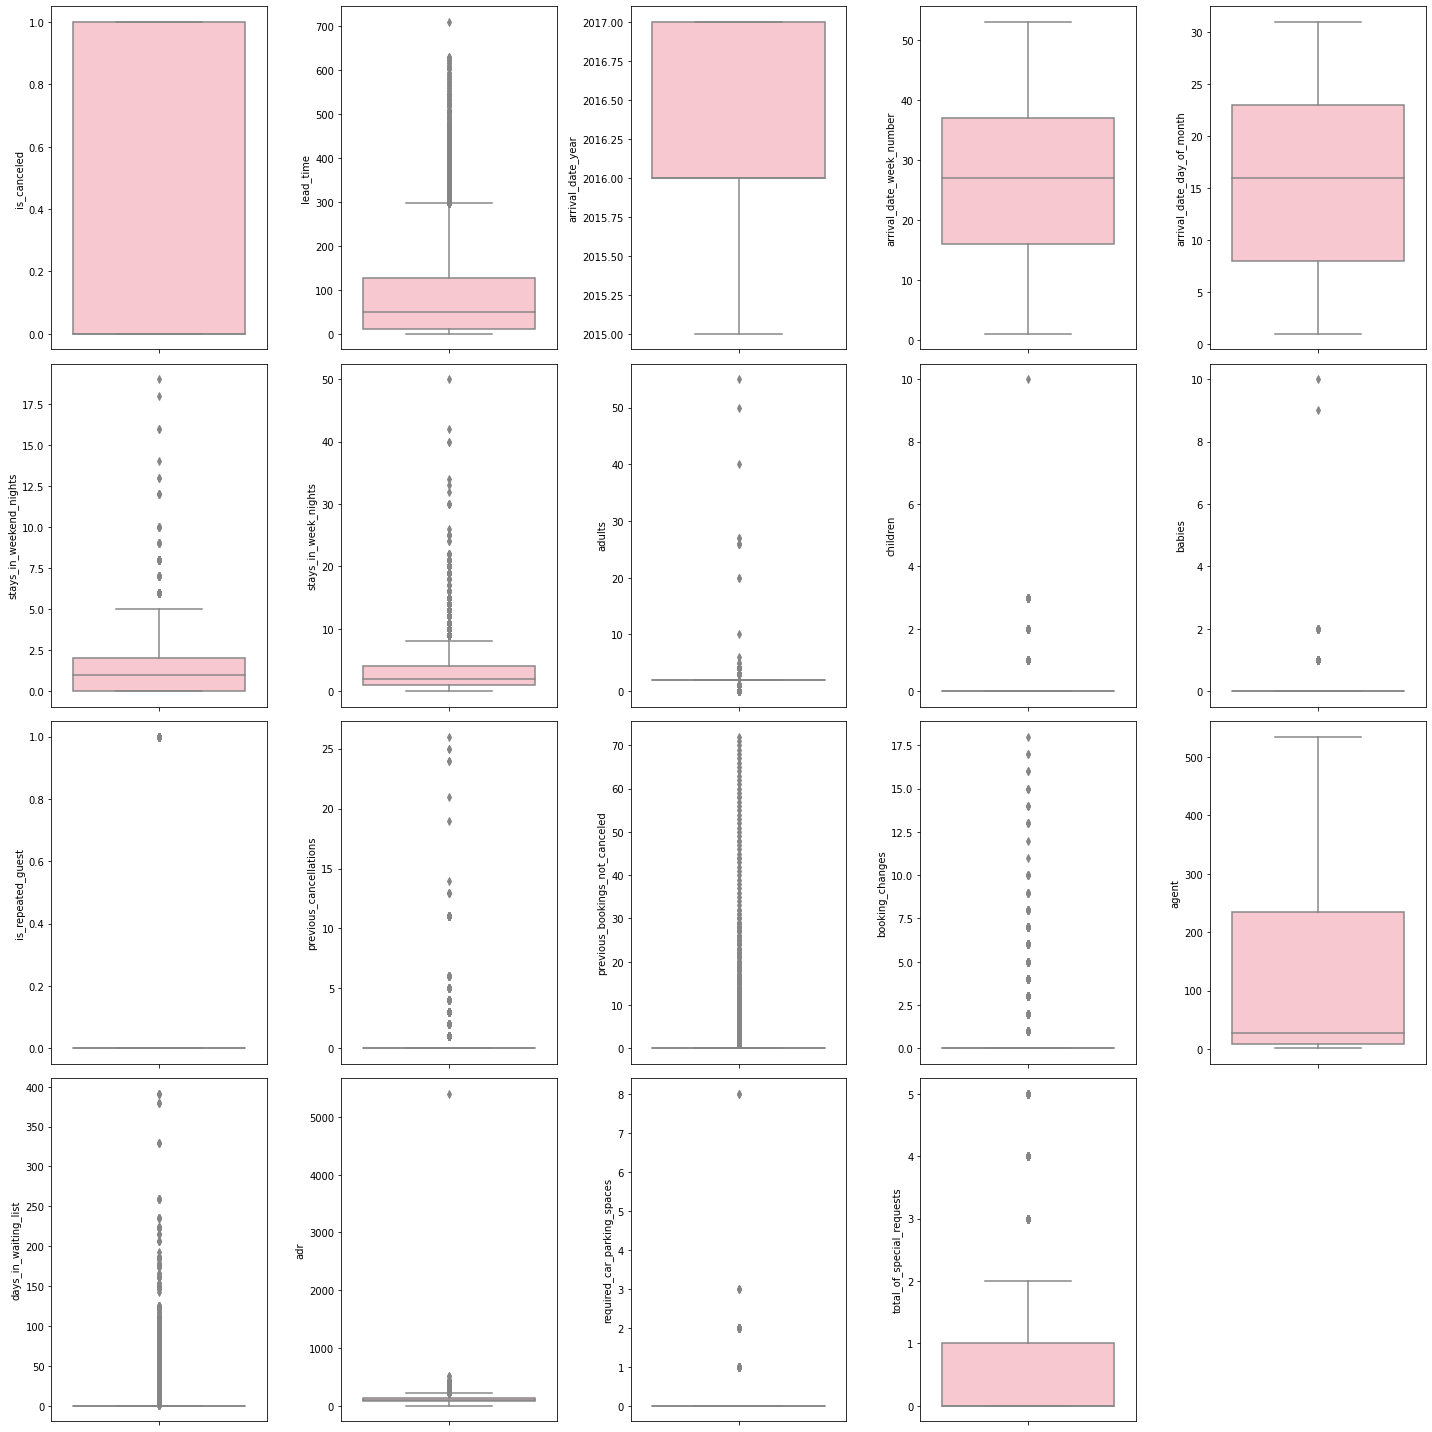

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(0, len(nums)):
    plt.subplot(4, 5, i+1)
    sns.boxplot(y=nums[i],data=df,color='pink')
    plt.tight_layout()


**Observation** :

Terdapat banyak outliers. Tetapi berdasarkan peruntukkan kolomnya, beberapa kolom dianggap wajar memiliki outliers tersebut, kecuali :
- `children` yang lebih dari 4
- `babies` yang lebih dari 4
- `adr` yang lebih dari 1000

Ketika fitur tersebut perlu di cek ke-sah-an datanya.

In [ ]:
#Berikut data children yang > 4
df[df['children']>4]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
328,Resort Hotel,1,55,2015,July,29,12,4,10,2,10,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,D,D,2,No Deposit,8,0,Contract,133.16,0,1,No-Show,2015-07-12


In [ ]:
#Berikut data children yang > 4
df[df['babies']>4]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
46619,City Hotel,0,37,2016,January,3,12,0,2,2,0,10,BB,PRT,Online TA,TA/TO,0,0,0,D,D,1,No Deposit,9,0,Transient,84.45,0,1,Check-Out,2016-01-14
78656,City Hotel,0,11,2015,October,42,11,2,1,1,0,9,BB,GBR,Corporate,Corporate,0,0,0,A,B,1,No Deposit,95,0,Transient-Party,95.00,0,0,Check-Out,2015-10-14


In [ ]:
#Berikut data adr yang > 1000
df[df['adr']>1000]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
48515,City Hotel,1,35,2016,March,13,25,0,1,2,0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,1,Non Refund,12,0,Transient,5400.0,0,0,Canceled,2016-02-19


**Observation**

Berdasarkan data tersebut,
- Index 328 masih mungkin terjadi, karena walaupun childrennya 10 tetapi adultsnya ada 2 dan jumlah menginapnya cukup lama. Sangat mungkin jika mereka sedang berlibur.
- Index 46619 dan 78656 dirasa tidak mungkin terjadi. Karena perbandingan antara adults dan babies yang tidak sesuai. Dimana jumlah babies 9 dan 10 dengan jumlah adults yang hanya 1 dan 2. Sehingga data ini akan di remove.
- Index 48515 memiliki adr 5400 sementara tidak ada permintaan khusus dan kasus khusus yang menyebabkan harga meningkat sangat tinggi. Tetapi melihat reservation statusnya yang cancel, kita dapat menarik insight bahwa beliau membatalkan pemesanan karena adr yang tidak realistis (bisa jadi disebabkan karena server atau lainnya). Sehingga dalam prosesnya, data ini akan diremove.

**Bussiness Insight**
- Nilai adr yang tidak wajar, seperti > 1000 akan menyebabkan pembatalan pemesanan.

#### **Handling Outlier**

In [ ]:
df = df.drop([46619,78656,48515])

In [ ]:
df.shape

(86628, 31)

*Handling Outliers DONE*

# Exploratory Data Analysis

## Statistical Summary

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,86628.0,0.276874,0.447456,0.0,0.0,0.0,1.0000,1.0
lead_time,86628.0,80.299499,86.075137,0.0,12.0,50.0,126.0000,709.0
arrival_date_year,86628.0,2016.212264,0.685971,2015.0,2016.0,2016.0,2017.0000,2017.0
arrival_date_week_number,86628.0,26.822101,13.651965,1.0,16.0,27.0,37.0000,53.0
arrival_date_day_of_month,86628.0,15.817957,8.836020,1.0,8.0,16.0,23.0000,31.0
stays_in_weekend_nights,86628.0,1.011497,1.027509,0.0,0.0,1.0,2.0000,19.0
stays_in_week_nights,86628.0,2.641986,2.035195,0.0,1.0,2.0,4.0000,50.0
adults,86628.0,1.880558,0.622265,0.0,2.0,2.0,2.0000,55.0
children,86628.0,0.139320,0.456919,0.0,0.0,0.0,0.0000,10.0
babies,86628.0,0.010643,0.104290,0.0,0.0,0.0,0.0000,2.0


**Bussiness Insight**
1. Rata-rata pengunjung melakukan pemesanan hotel jauh-jauh hari yaitu sekitar 50-80 hari. Tetapi ada juga yang memesan dalam waktu dekat dan ada yang lebih dari 1 tahun. Karena banyak yang tidak melakukan booking, perlu adanya antisipasi terkait fasilitas yang ada.
2. Rata-rata pengunjung menginap di weekday 2-3 hari.
3. Rata-rata jumlah orang dewasa yang menginap adalah 1-2 orang dan kebanyakan mereka tidak membawa anak dan bayi.
4. Ada pengunjung yang seringkali melakukan pembatalan pemesanan sampai 26 kali.
5. Ada pengunjung yang loyal sampai melakukan pemesanan sampai 72 kali tanpa cancel.
6. Rata-rata pengunjung tidak masuk ke dalam waiting list. It's good.
7. Rata-rata ADR 107 dan cukup bervariatif.
8. Rata-rata pengunjung tidak memerlukan parkir mobil. Tetapi tetap ada yang memerlukan. Jadi perlu adanya perhitungan yang efisien untuk menentukan jumlah ruang parkir.

**Observation**
1. Karena `is_canceled` dan `is_repeated_guest` adalah integer, kita perlu mengobservasi kemudian perihal ini.
2. Begitupun dengan `arrival_date_year`, `arrival_date_week_number`, `arrival_date_day_of_month`.
3. Ada pelanggan yang menunggu cukup lama. Perlu dicari tahu penyebabnya.

In [ ]:
df.describe(include="object").T

,count,unique,top,freq
hotel,86628,2,City Hotel,53038
arrival_date_month,86628,12,August,11194
meal,86628,5,BB,67408
country,86628,178,PRT,26858
market_segment,86628,8,Online TA,51281
distribution_channel,86628,5,TA/TO,68646
reserved_room_type,86628,9,A,56001
assigned_room_type,86628,11,A,46084
deposit_type,86628,3,No Deposit,85484
customer_type,86628,4,Transient,71360


**Intrepretation**
1. City Hotel lebih populer ketimbang Resort Hotel.
2. Mayoritas pengunjung hanya breakfast saja. 
3. Warga lokal mendominasi sebagai pelanggan.
4. Pemasaran cukup baik karena dapat menjangkau 177 negara lainnya.
5. Market segment dan distributin channel didominasi oleh Travel Agent.
6. Tipe kamar paling populer adalah tipe A.
7. Kebanyakan pelanggan tidak melakukan deposit.
8. Tipe pelanggan transient sangat mendominasi. Perlu adanya promo untuk pelanggan lainnya.
9. Agent 9 merupakan agen yang paling sering membawa pelanggan.

**Observation**
1. Kita belum dapat mengetahui pada bulan apa biasanya pemesanan meningkat, karena berdasarkan data diatas kurang representatif sebab agustus adalah bulan yang pada data ini ada di ketiga tahun tersebut, dimana data lainnya ada yang hanya dua tahun saja.
2. Bisa dipertimbangkan apakah masih perlu untuk menawarkan makanan diluar breakfast.

In [ ]:
df.describe(include="datetime").T

,count,unique,top,freq,first,last
reservation_status_date,86628,926,2016-02-14,210,2014-10-17,2017-09-14


**Bussiness Insight** 
1. Pemesanan paling tinggi yaitu pada 14 Februari 2016 sebanyak 210.

## Univariate Analysis

#### Visualisasi Target Variable

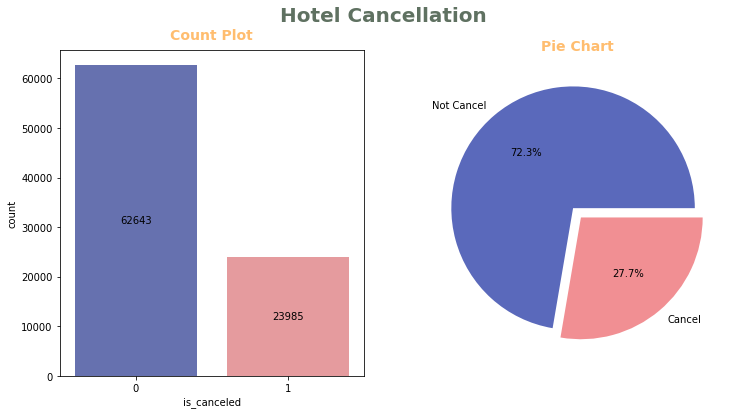

<Figure size 720x432 with 0 Axes>

In [ ]:
#Membuat Subplot untuk Target Variable
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Hotel Cancellation", size = 20, color = '#5F7161', weight="bold")
axs = [ax1, ax2]

# Countplot target
plt.figure(figsize=(10,6))
ax1 = sns.countplot(x="is_canceled",data=df, ax=ax1, palette=["#5A69BB","#F18F93"])
ax1.set_title("Count Plot", size = 14, color = '#FFBD6F', weight="bold",pad=10)

# Memberikan keterangan jumlah pada count plot
for p in ax1.patches:
  x = p.get_x() + p.get_width() / 2
  y = p.get_height()
  ax1.annotate(round(p.get_height()),(x,y/2), ha='center', va='center')

#Menentukan Attribute Pie Chart
label = ["Not Cancel", "Cancel"]
value = df["is_canceled"].value_counts()
explode = (0.05, 0.05)

#Membuat Pie Chart
ax2.pie(x=value, labels=label, colors=["#5A69BB","#F18F93"],autopct='%1.1f%%', pctdistance=0.6,explode=explode)
ax2.set_title("Pie Chart", size = 14, color = '#FFBD6F', weight="bold",pad=10)

#Mengadjust Subplot
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.78, wspace=0.4, hspace=None);

**Observation**
- Persentase customer yang tidak cancel memang jauh lebih besar dari yang cancel, namun 27,7% cukup besar untuk diperhatikan. Mengingat pembatalan booking memberikan pengaruh kepada revenue karena tidak dapat digantikan di kemudian hari. Sehingga diperlukan efektifitas dari proses booking. Hal ini yang menjadi latar belakang proyek ini.
- Target imbalance.

#### Visualisasi Categorical & Date Feature

In [ ]:
#Sebelumnya kolom categorical sudah didefine sebagai cats, kita tambahkan dengan kolom lainnya yang akan ditampilkan dengan countplot.
new_cats = []
new = ['arrival_date_year','is_repeated_guest']

for i in cats:
  new_cats.append(i)

for i in new:
  new_cats.append(i)

#Remove kolom yang kurang bagus menggunakan countplot
new_cats.remove('country')
new_cats.remove('arrival_date_month')

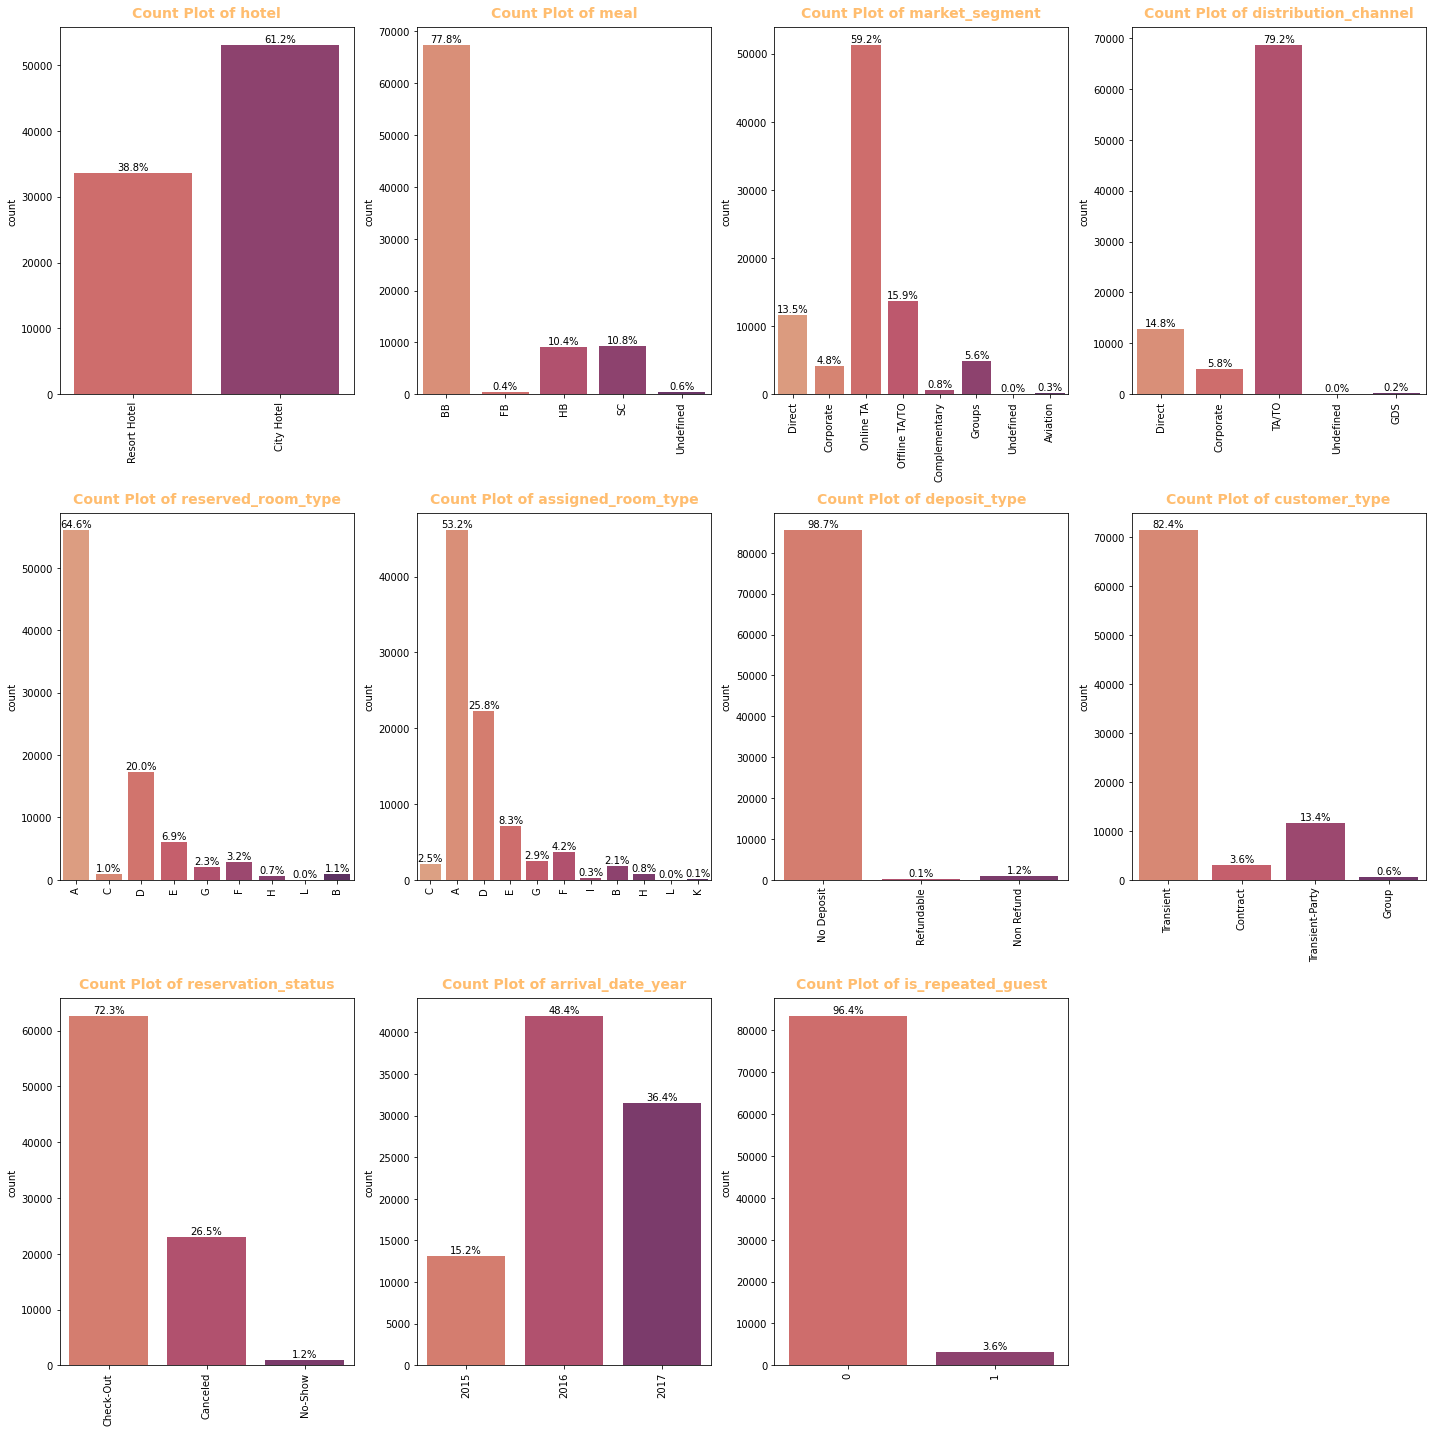

In [ ]:
plt.figure(figsize=(20,20))

#Menampilkan countplot dari beberapa feature
for i in range(0, len(new_cats)):
    plt.subplot(3, 4, i+1)
    ax = sns.countplot(data=df, x=new_cats[i], palette='flare')
    ax.set_title(f"Count Plot of {new_cats[i]}", size = 14, color = '#FFBD6F', weight="bold",pad=10)
    
    #Menampilkan persentase
    total = len(df)
    for p in ax.patches:
      percentage = f'{100 * p.get_height() / total:.1f}%\n'
      x = p.get_x() + p.get_width() / 2
      y = p.get_height()
      ax.annotate(percentage, (x, y), ha='center', va='center')
    
    #Tampilan layout
    plt.xticks(rotation=90)
    plt.xlabel("")
    plt.tight_layout()

Text(0.5, 1.0, 'Count Plot of Country')

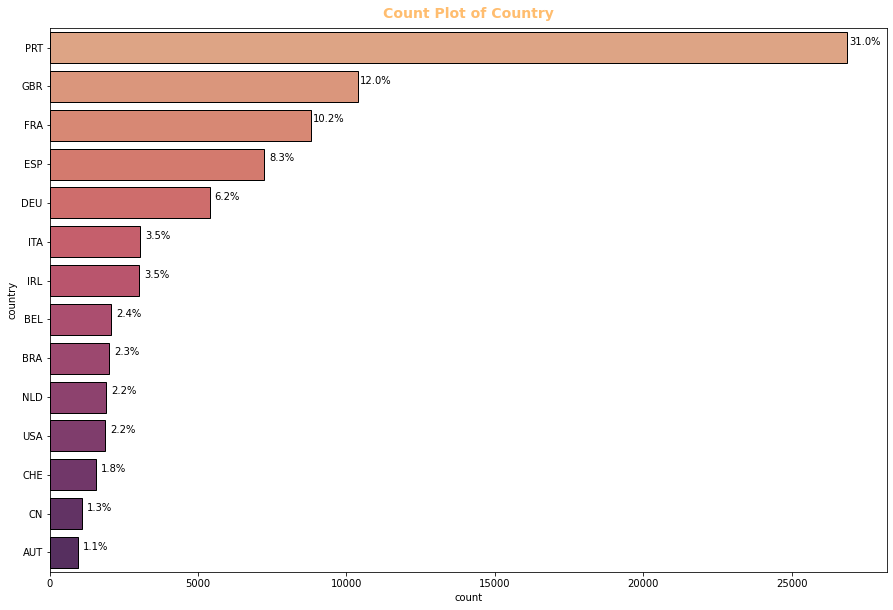

In [ ]:
#Membuat count table untuk country
country = df.groupby(['country']).agg(count = ('country','count')).sort_values('count',ascending=False).reset_index()

#Memvisualisasikan country
plt.figure(figsize=(15,10))
ax = sns.barplot(x=country["count"],y=country["country"][:14],data=country,palette="flare",edgecolor="black")

#Menampilkan jumlah tiap country
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_width() / total:.1f}%\n'
    y = p.get_y() +p.get_height() / 2
    x = p.get_width() + 600
    ax.annotate(percentage, (x, y), ha='center', va='center')

#Menampilkan judul
ax.set_title("Count Plot of Country", size = 14, color = '#FFBD6F', weight="bold",pad=10)

Text(0.5, 1.0, 'Count Plot of Agent')

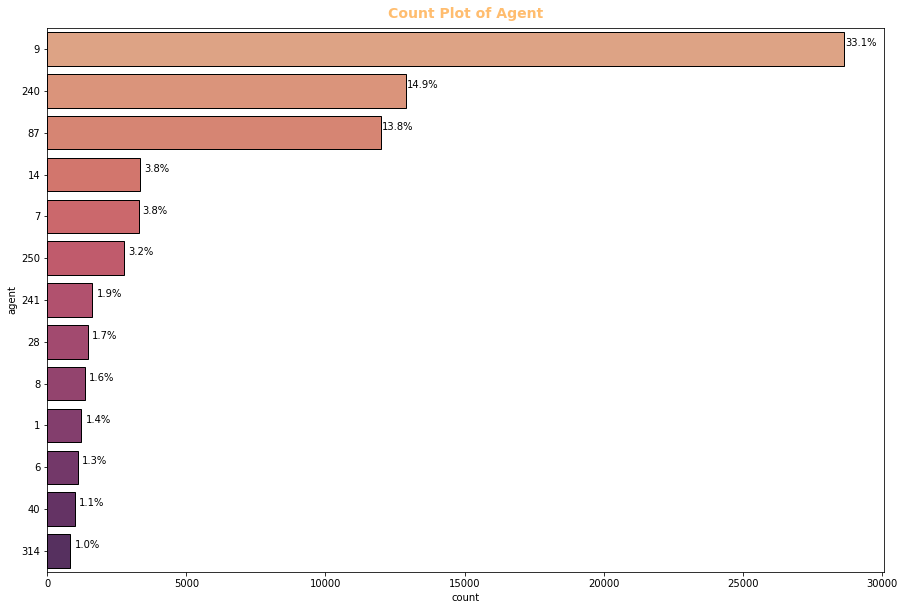

In [ ]:
copy_df = df.copy()
copy_df['agent'] = copy_df['agent'].astype(str)

#Membuat count table untuk country
agent = copy_df.groupby(['agent']).agg(count = ('agent','count')).sort_values('count',ascending=False).reset_index()

#Memvisualisasikan country
plt.figure(figsize=(15,10))
ax = sns.barplot(x=agent["count"],y=agent["agent"][:13],data=agent,palette="flare",edgecolor="black")

#Menampilkan jumlah tiap country
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_width() / total:.1f}%\n'
    y = p.get_y() +p.get_height() / 2
    x = p.get_width() + 600
    ax.annotate(percentage, (x, y), ha='center', va='center')

#Menampilkan judul
ax.set_title("Count Plot of Agent", size = 14, color = '#FFBD6F', weight="bold",pad=10)

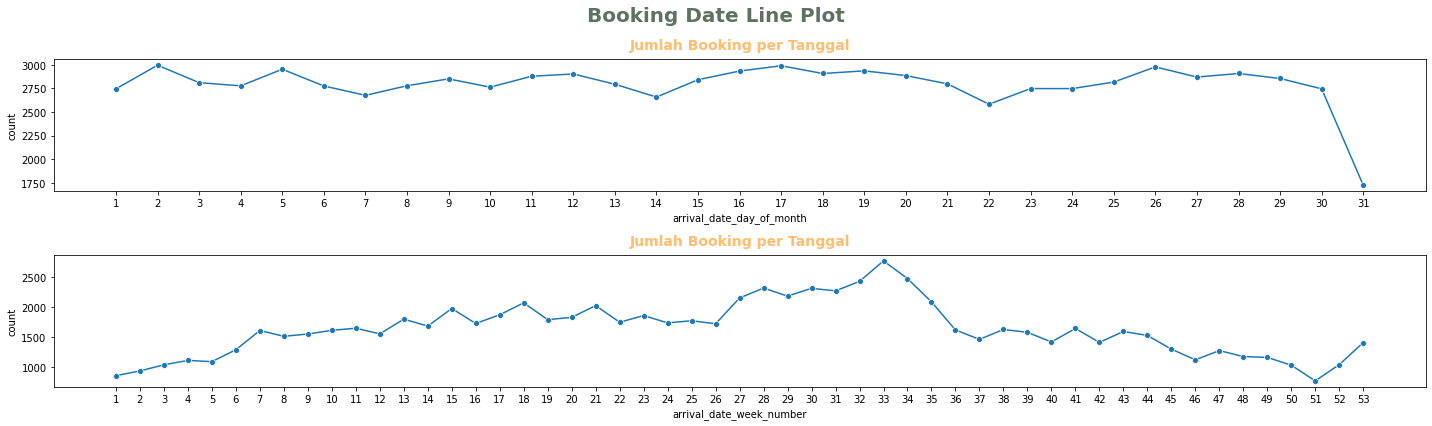

In [ ]:
#Membuat Subplot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6))
fig.suptitle("Booking Date Line Plot", size = 20, color = '#5F7161', weight="bold")
axs = [ax1, ax2]

#Membuat count table untuk date
date = df.groupby(['arrival_date_day_of_month']).agg(count = ('arrival_date_day_of_month','count')).reset_index()

#Membuat lineplot untuk date
ax1 = sns.lineplot(data=date, x='arrival_date_day_of_month', y='count', ax=ax1, marker = "o", palette = "#F18F93")
ax1.set_title("Jumlah Booking per Tanggal", size = 14, color = '#FFBD6F', weight="bold",pad=10)
ax1.set_xticks(range(1,32))

#Membuat count table untuk week
week = df.groupby(['arrival_date_week_number']).agg(count = ('arrival_date_week_number','count')).reset_index()

#Membuat lineplot untuk week
ax2 = sns.lineplot(data=week, x='arrival_date_week_number', y='count', ax=ax2, marker = "o", palette = "#F18F93")
ax2.set_title("Jumlah Booking per Tanggal", size = 14, color = '#FFBD6F', weight="bold",pad=10)
ax2.set_xticks(range(1,54))

#Tampilan layout
plt.tight_layout()

**Bussiness Insight**
1. Sebanyak 61,2% pemesan memilih City Hotel ketimbang Resort Hotel. Jelas bahwa City Hotel lebih populer.
2. Hampir semua pemesan memilih BB untuk meal. Hanya kurang dari 30% yang memilih diluar itu. Hal ini bisa dijadikan patokan untuk memprediksi bahan makanan yang dibutuhkan.
3. Hampir semua pemesan memilih tipe kamar A. Kemudian disusul tipe D sebanyak 20%. Selebihnya terhitung sangat minim.
4. Terlihat pada tipe kamar A yang dipesan dengan yang diassign menurun tetapi tipe kamar lainnya meningkat. Dimungkinkan adanya overbook pada tipe kamar A.
5. Hampir semua pemesan memilih untuk tidak deposit. Perlu ditinjau apakah hal tersebut merugikan atau tidak.
6. Ternyata sangat sedikit pelanggan yang melakukan repeat book. Perlu adanya langkah supaya keinginan untuk repeat guest dari tiap pelanggan meningkat. Karena repeat guest artinya mereka puas terhadap fasilitas hotel, hal ini juga dapat mendatangkan pelanggan baru.
7. Kedua hotel ini sangat populer di lingkungan warga lokal. Selain itu, banyak negara yang berkunjung juga seperti UK (GBR) yang menempati posisi kedua sebanyak 12% dan Prancis (FRA) ketiga sebanyak 10,2%. Selebihnya hanya kurang dari 10%.
8. Agent dengan ID 9 melakukan booking paling banyak yaitu 33,1%. Disusul oleh ID 240 dan 87. Selebihnya hanya melakukan booking kurang dari 5%.
9. Jumlah booking tiap tanggal hampir rata berkisar 2600 sampai 3000 kecuali tanggal 31 kurang dari 1750. Hal ini wajar karena kemunculan tanggal 31 dalam satu tahun setengahnya dari kemunculan tanggal lainnya.

**Observation**
1. Jika diperhatikan dari fungsi fitur reservation_status dan persentasenya, besar kemungkinan ini duplikat dengan is_canceled.
2. arrival_date_year tidak dapat ditinjau karena data tidak sama rata tiap tahunnya.

#### Visualisasi Numerical Feature

In [ ]:
#Sebelumnya kita telah memiliki list numerical, namun akan di remove beberapa sesuai kebutuhan
new_nums = nums.copy()
new_nums.remove('is_canceled')
new_nums.remove('arrival_date_year')
new_nums.remove('arrival_date_week_number')
new_nums.remove('arrival_date_day_of_month')
new_nums.remove('is_repeated_guest')
new_nums.remove('agent')

In [ ]:
new_nums

['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

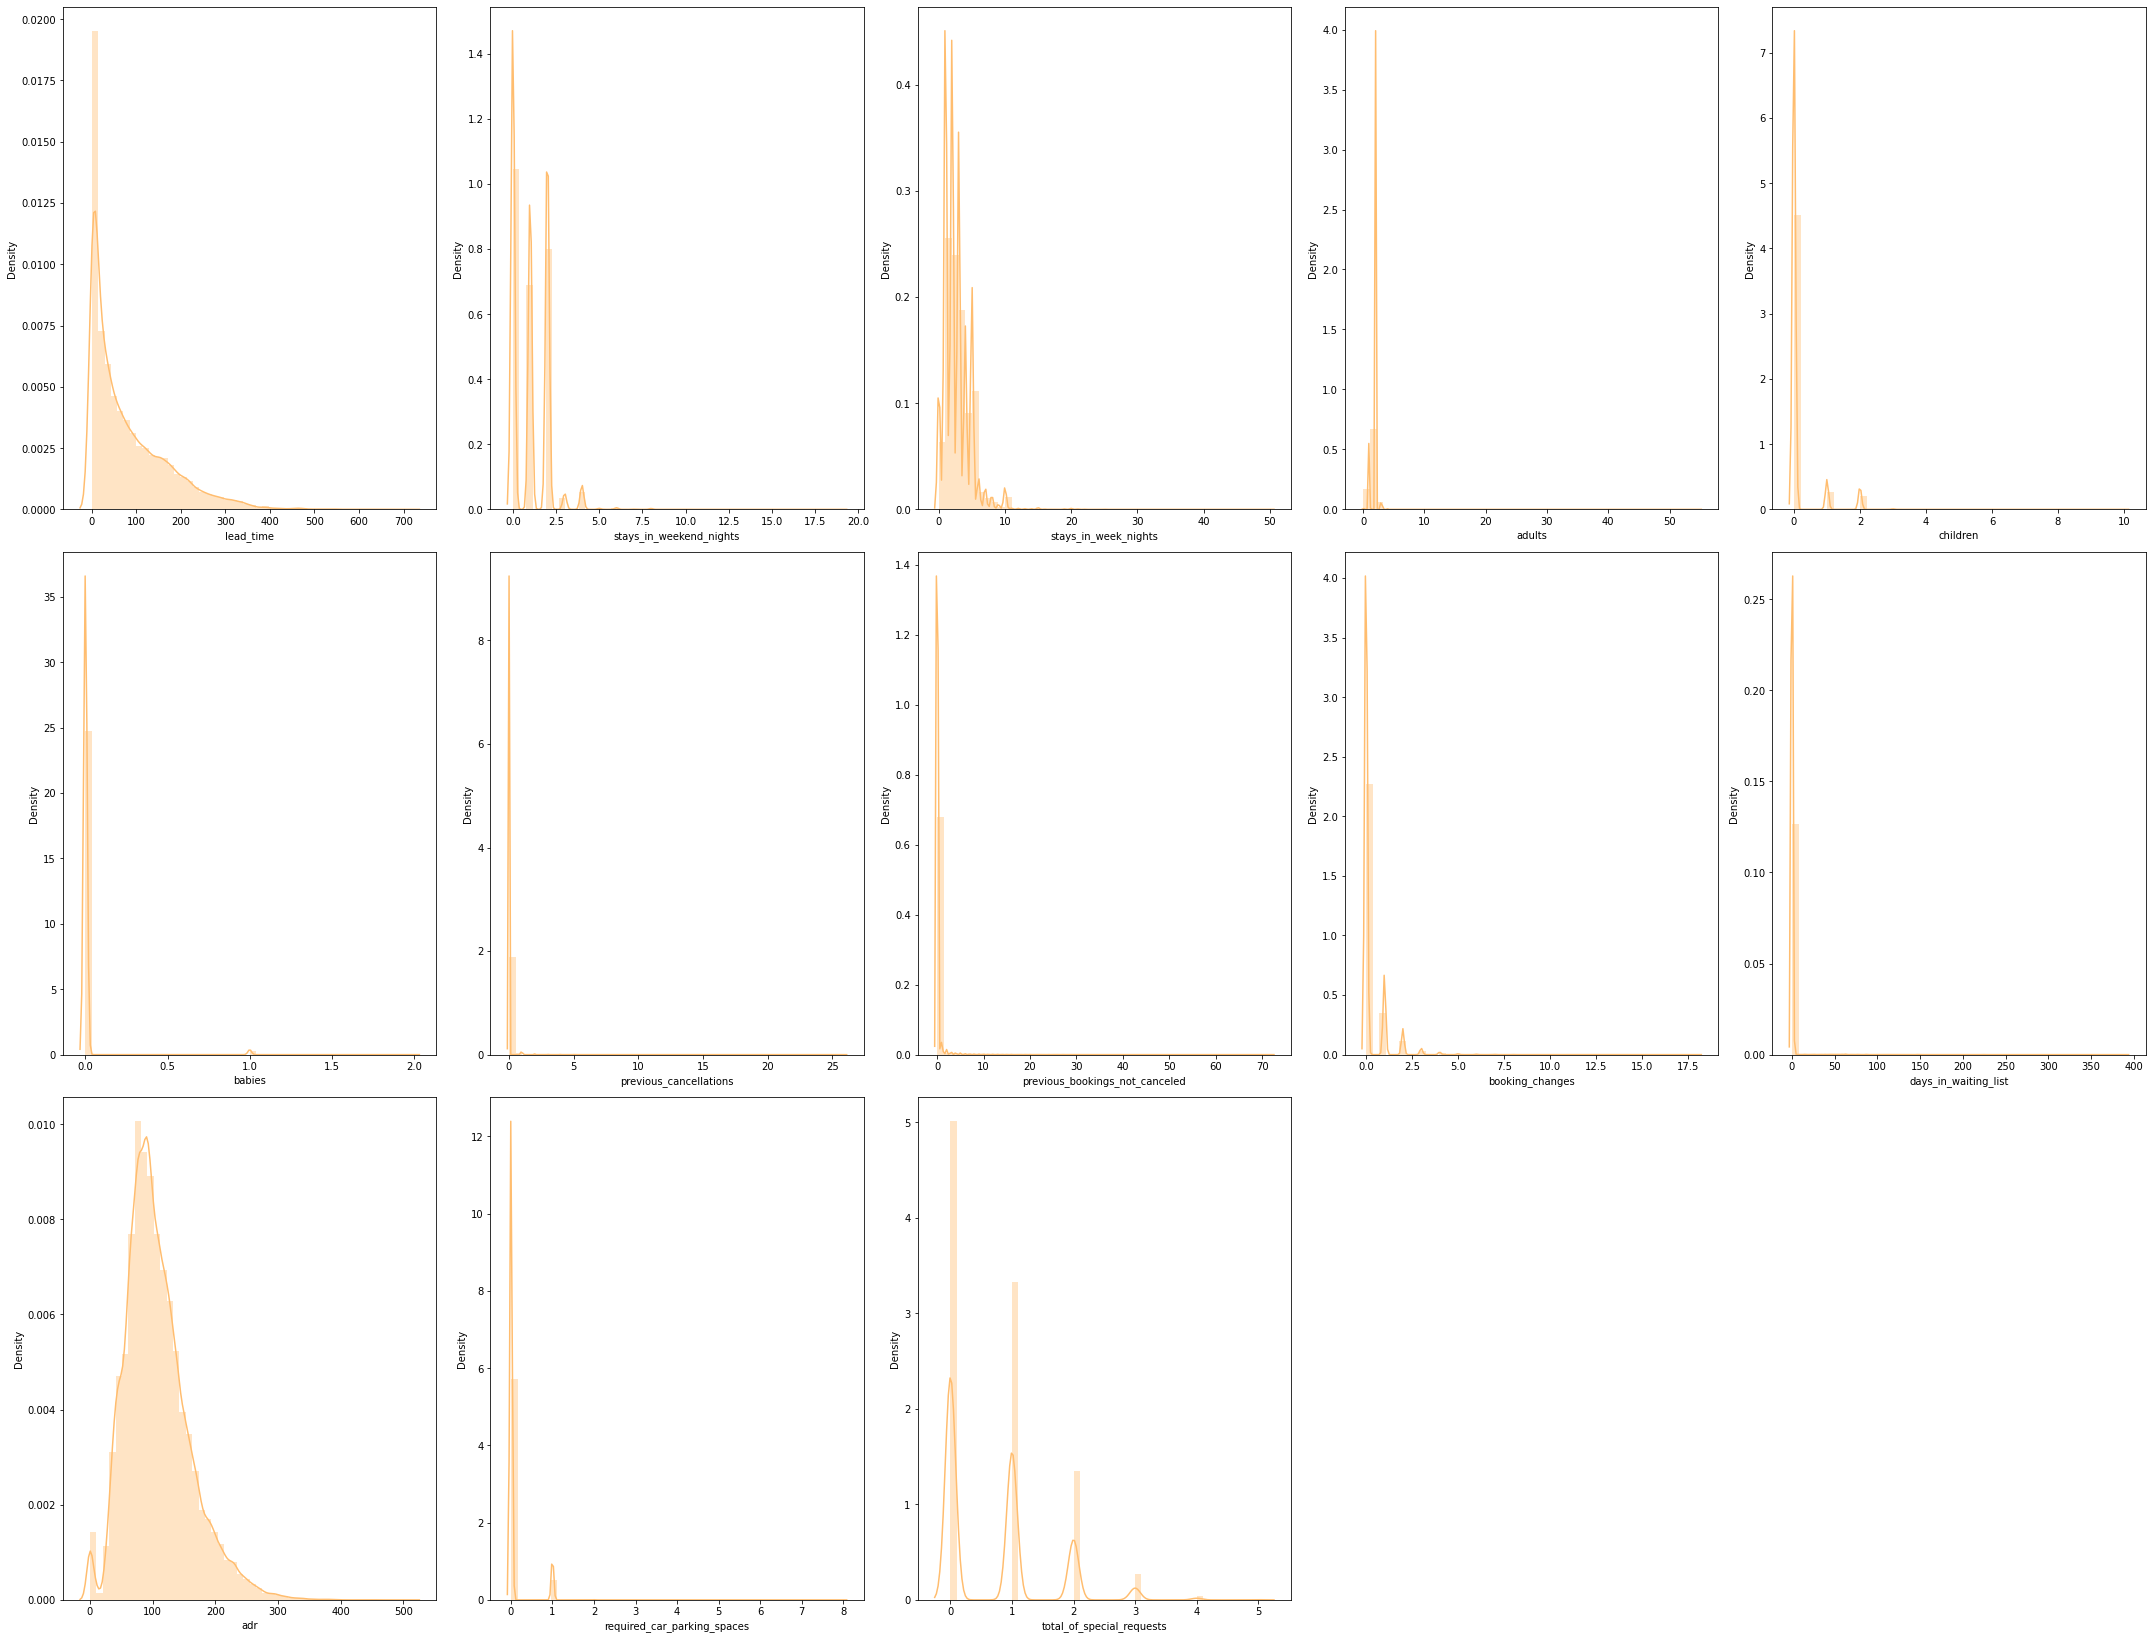

In [ ]:
plt.figure(figsize=(30, 30))
for i in range(0, len(new_nums)):
    plt.subplot(4, 5, i+1)
    sns.distplot(df[new_nums[i]],color = '#FFBD6F')
    plt.tight_layout()


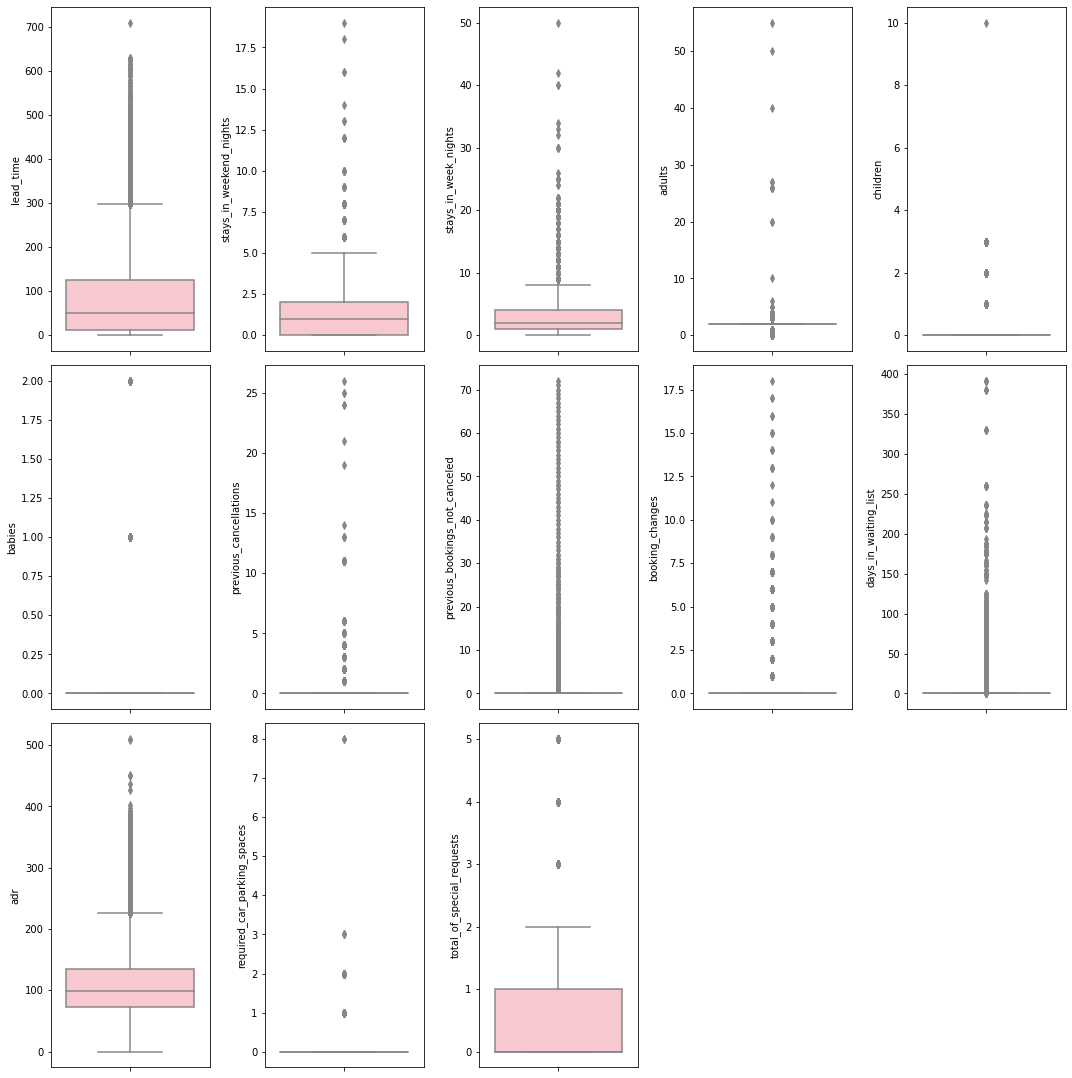

In [ ]:
#Memvisualisasikan Numerical Metric
plt.figure(figsize=(15, 20))
for i in range(0, len(new_nums)):
    plt.subplot(4, 5, i+1)
    sns.boxplot(y=new_nums[i],data=df,color='pink')
    plt.tight_layout()


**Bussiness Insight**
1. Melihat dari previous cancellations dan not cancelled, sebagian besar pelanggan adalah pelanggan baru dimana ia tidak pernah cancel dan tidak cancel.
2. Booking kebanyakan sudah final melihat booking changed nya nol.


Selebihnya sudah tercantum saat statistical summary.

# Machine Learning

## Baseline Model

In [ ]:
data = df.copy() #data yang digunakan untuk baseline

### Filtering Features

#### Correlation

<Axes: >

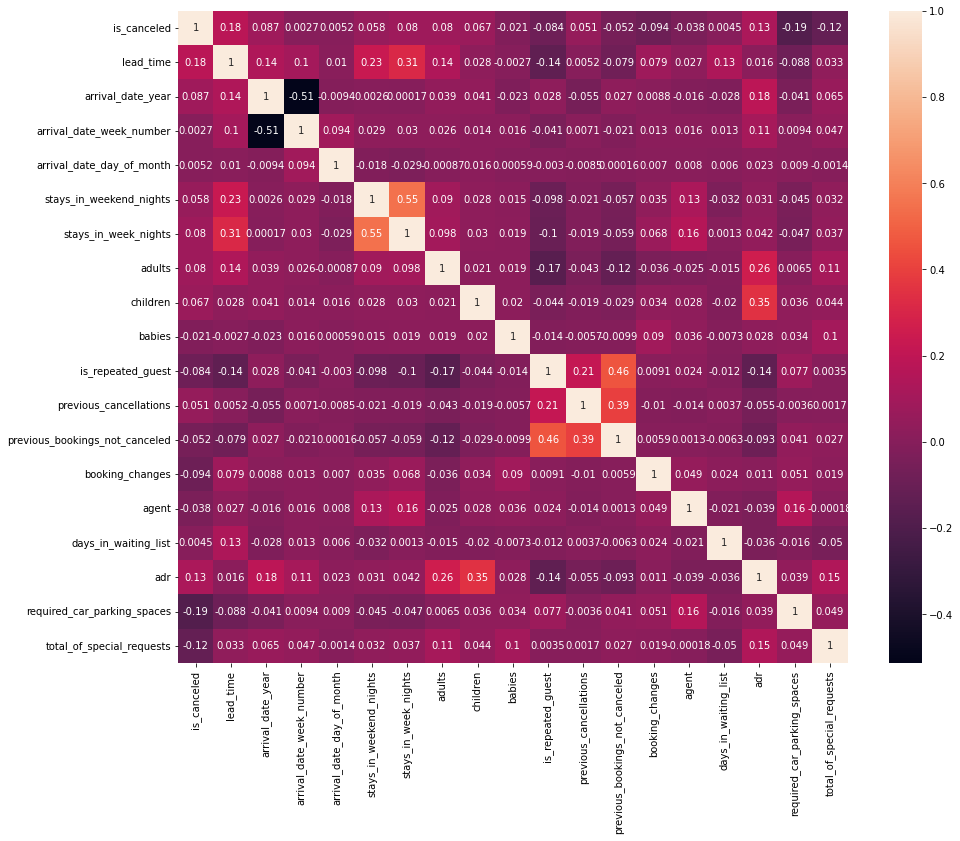

In [ ]:
plt.figure(figsize=(15,12))
sns.heatmap(data.corr(), annot = True)

Tidak ada yang berkorelasi tinggi, sehingga *tidak ada yang di drop*

#### Filtering by Knowledge

- Data mengenai tanggal kedatangan, tidak terkait dengan cancellation.
- Meal juga tidak terkait dengan cancellation.
- Reservation Status duplikat dengan is canceled
- Reservation status date juga tidak terkait dengan cancellation.
- Tipe Kamar juga dikesampingkan.

In [ ]:
data.drop(columns=["arrival_date_year",'arrival_date_month','arrival_date_week_number','arrival_date_day_of_month','meal','reservation_status','reservation_status_date',"reserved_room_type",'assigned_room_type'],inplace=True)

#### Features Engineering

**Apakah pengunjung adalah warga lokal?**

Saya merasa data 'country' bisa dimanfaatkan menjadi data yang lebih efektif yaitu warga Portugis atau turis. Karena seperti yang kita tahu, salah satu fungsi hotel adalah untuk turis menginap saat berlibur/urusan pekerjaan.

In [ ]:
country = data['country'].unique().tolist()
country.remove('PRT')

for i in country:
  data['country'].mask(data['country'] == i, 0, inplace=True)

In [ ]:
data['country'].mask(data['country'] == 'PRT', 1, inplace=True)

In [ ]:
data['country'].unique()

array([0, 1], dtype=object)

In [ ]:
data = data.rename(columns={"country": "is_local"})
data['is_local'] = data['is_local'].astype(int)

### Encoding

####Label Encoding

In [ ]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
data['hotel']= label_encoder.fit_transform(data['hotel'])

####One Hot encoding

In [ ]:
data =pd.get_dummies(data=data,columns=['market_segment', 'distribution_channel', 'deposit_type','customer_type'])

In [ ]:
data.head()

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_local,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
2,1,0,7,0,1,1,0,0,0,0,0,0,0,87,0,75.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
3,1,0,13,0,1,1,0,0,0,0,0,0,0,304,0,75.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,1,0,14,0,2,2,0,0,0,0,0,0,0,240,0,98.0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0
6,1,0,0,0,2,2,0,0,1,0,0,0,0,87,0,107.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
7,1,0,9,0,2,2,0,0,1,0,0,0,0,303,0,103.0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0


### Split Data

In [ ]:
X = data.drop('is_canceled', axis=1) #Fitur
y = data['is_canceled'] #target

In [ ]:
X_train, X_test,y_train,y_test = train_test_split(X,
                                                y,
                                                test_size = 0.2,
                                                random_state = 42)
#training -> train 80%
#testing ->  test 20%

### Modeling

In [ ]:
# RandomForestClassifier
RF = RandomForestClassifier(random_state=42)
RF.fit(X_train, y_train)
pred_RF = RF.predict(X_test)

# DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train,y_train)
pred_DT = dt.predict(X_test)

# LogisticRegression
logr = linear_model.LogisticRegression()
logr.fit(X_train,y_train)
pred_logr = logr.predict(X_test)

# XGBoost
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
pred_xgb = xgb.predict(X_test)

# Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
pred_gb = gb.predict(X_test)

# LGBM
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
pred_lgbm = lgbm.predict(X_test)

# ExtraTreesClassifier
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)
pred_etc = etc.predict(X_test)

# HistGradientBoostingClasifier
hgbc = HistGradientBoostingClassifier(random_state=42)
hgbc.fit(X_train,y_train)
pred_hgbc = hgbc.predict(X_test)

### Evaluation

In [ ]:
models = pd.DataFrame({
    'Model' : ['RandomForestClassifier',
               'DecisionTreeClassifier',
               'LogisticRegression',
               'XGBClassifier',
               'GradientBoostingClassifier',
               'LGBMClassifier',
               'ExtraTreesClassifier',
               'HistGradientBoostingClassifier'],
    'Recall' : [recall_score(y_test, pred_RF),
             recall_score(y_test, pred_DT),
             recall_score(y_test, pred_logr),
             recall_score(y_test, pred_xgb),
             recall_score(y_test, pred_gb),
             recall_score(y_test, pred_lgbm),
             recall_score(y_test, pred_etc),
             recall_score(y_test, pred_hgbc)],   
    'AUC' : [roc_auc_score(y_test, pred_RF),
             roc_auc_score(y_test, pred_DT),
             roc_auc_score(y_test, pred_logr),
             roc_auc_score(y_test, pred_xgb),
             roc_auc_score(y_test, pred_gb),
             roc_auc_score(y_test, pred_lgbm),
             roc_auc_score(y_test, pred_etc),
             roc_auc_score(y_test, pred_hgbc)],
    'F1 Score':[f1_score(y_test, pred_RF),
                f1_score(y_test, pred_DT),
                f1_score(y_test, pred_logr),
                f1_score(y_test, pred_xgb),
                f1_score(y_test, pred_gb),
                f1_score(y_test, pred_lgbm),
                f1_score(y_test, pred_etc),
                f1_score(y_test, pred_hgbc)],
    'precision':[precision_score(y_test, pred_RF),
                precision_score(y_test, pred_DT),
                precision_score(y_test, pred_logr),
                precision_score(y_test, pred_xgb),
                precision_score(y_test, pred_gb),
                precision_score(y_test, pred_lgbm),
                precision_score(y_test, pred_etc),
                precision_score(y_test, pred_hgbc)],
    'accuracy':[accuracy_score(y_test, pred_RF),
                accuracy_score(y_test, pred_DT),
                accuracy_score(y_test, pred_logr),
                accuracy_score(y_test, pred_xgb),
                accuracy_score(y_test, pred_gb),
                accuracy_score(y_test, pred_lgbm),
                accuracy_score(y_test, pred_etc),
                accuracy_score(y_test, pred_hgbc)]
})

In [ ]:
#Menampilkan Hasil Dataframe
models
(models.style
                     .background_gradient(subset=['Recall','AUC','F1 Score','precision','accuracy'])
                     .highlight_max(subset=['Recall','AUC','F1 Score','precision','accuracy'], color="purple")
                     .set_caption("Model Performance Baseline")
                     .format({"Recall": "{:.2%}",
                              "AUC": "{:.2%}",
                              "F1 Score": "{:.2%}",
                              "precision": "{:.2%}",
                              "accuracy": "{:.2%}"}))

,Model,Recall,AUC,F1 Score,precision,accuracy
0,RandomForestClassifier,62.83%,76.60%,66.79%,71.27%,82.79%
1,DecisionTreeClassifier,61.57%,73.34%,61.33%,61.09%,78.62%
2,LogisticRegression,40.73%,66.05%,49.85%,64.21%,77.43%
3,XGBClassifier,63.82%,77.65%,68.54%,74.03%,83.87%
4,GradientBoostingClassifier,56.67%,74.51%,64.11%,73.81%,82.53%
5,LGBMClassifier,62.33%,76.93%,67.52%,73.66%,83.49%
6,ExtraTreesClassifier,62.33%,75.79%,65.39%,68.77%,81.84%
7,HistGradientBoostingClassifier,61.89%,76.83%,67.43%,74.06%,83.54%


## Undersampling Model

In [ ]:
# fit predictor and target variable
rus = RandomUnderSampler(random_state=42, replacement=True)
x_rus, y_rus = rus.fit_resample(X_train, y_train)

### Modeling

In [ ]:
# RandomForestClassifier
RF_under = RandomForestClassifier(random_state=42)
RF_under.fit(x_rus, y_rus)
pred_RF_under = RF_under.predict(X_test)

# DecisionTreeClassifier
dt_under = DecisionTreeClassifier(random_state=42)
dt_under.fit(x_rus, y_rus)
pred_DT_under = dt_under.predict(X_test)

# LogisticRegression
logr_under = linear_model.LogisticRegression()
logr_under.fit(x_rus, y_rus)
pred_logr_under = logr_under.predict(X_test)

# XGBoost
xgb_under = XGBClassifier()
xgb_under.fit(x_rus, y_rus)
pred_xgb_under = xgb_under.predict(X_test)

# Gradient Boosting
gb_under = GradientBoostingClassifier()
gb_under.fit(x_rus, y_rus)
pred_gb_under = gb_under.predict(X_test)

# LGBM
lgbm_under = LGBMClassifier()
lgbm_under.fit(x_rus, y_rus)
pred_lgbm_under = lgbm_under.predict(X_test)

# ExtraTreesClassifier
etc_under = ExtraTreesClassifier()
etc_under.fit(x_rus, y_rus)
pred_etc_under = etc_under.predict(X_test)

# HistGradientBoostingClasifier
hgbc_under = HistGradientBoostingClassifier(random_state=42)
hgbc_under.fit(x_rus, y_rus)
pred_hgbc_under = hgbc_under.predict(X_test)

### Evaluation

In [ ]:
from sklearn.metrics import recall_score
models_under = pd.DataFrame({
    'Model' : ['RandomForestClassifier',
               'DecisionTreeClassifier',
               'LogisticRegression',
               'XGBClassifier',
               'GradientBoostingClassifier',
               'LGBMClassifier',
               'ExtraTreesClassifier',
               'HistGradientBoostingClassifier'],
    'Recall' : [recall_score(y_test, pred_RF_under),
             recall_score(y_test, pred_DT_under),
             recall_score(y_test, pred_logr_under),
             recall_score(y_test, pred_xgb_under),
             recall_score(y_test, pred_gb_under),
             recall_score(y_test, pred_lgbm_under),
             recall_score(y_test, pred_etc_under),
             recall_score(y_test, pred_hgbc_under)],   
    'AUC' : [roc_auc_score(y_test, pred_RF_under),
             roc_auc_score(y_test, pred_DT_under),
             roc_auc_score(y_test, pred_logr_under),
             roc_auc_score(y_test, pred_xgb_under),
             roc_auc_score(y_test, pred_gb_under),
             roc_auc_score(y_test, pred_lgbm_under),
             roc_auc_score(y_test, pred_etc_under),
             roc_auc_score(y_test, pred_hgbc_under)],
    'F1 Score':[f1_score(y_test, pred_RF_under),
                f1_score(y_test, pred_DT_under),
                f1_score(y_test, pred_logr_under),
                f1_score(y_test, pred_xgb_under),
                f1_score(y_test, pred_gb_under),
                f1_score(y_test, pred_lgbm_under),
                f1_score(y_test, pred_etc_under),
                f1_score(y_test, pred_hgbc_under)],
    'precision':[precision_score(y_test, pred_RF_under),
                precision_score(y_test, pred_DT_under),
                precision_score(y_test, pred_logr_under),
                precision_score(y_test, pred_xgb_under),
                precision_score(y_test, pred_gb_under),
                precision_score(y_test, pred_lgbm_under),
                precision_score(y_test, pred_etc_under),
                precision_score(y_test, pred_hgbc_under)],
    'accuracy':[accuracy_score(y_test, pred_RF_under),
                accuracy_score(y_test, pred_DT_under),
                accuracy_score(y_test, pred_logr_under),
                accuracy_score(y_test, pred_xgb_under),
                accuracy_score(y_test, pred_gb_under),
                accuracy_score(y_test, pred_lgbm_under),
                accuracy_score(y_test, pred_etc_under),
                accuracy_score(y_test, pred_hgbc_under)]
})

In [ ]:
#Menampilkan Hasil Dataframe
models_under
(models_under.style
                     .background_gradient(subset=['Recall','AUC','F1 Score','precision','accuracy'])
                     .highlight_max(subset=['Recall','AUC','F1 Score','precision','accuracy'], color="purple")
                     .set_caption("Model Performance Undersampling")
                     .format({"Recall": "{:.2%}",
                              "AUC": "{:.2%}",
                              "F1 Score": "{:.2%}",
                              "precision": "{:.2%}",
                              "accuracy": "{:.2%}"}))

,Model,Recall,AUC,F1 Score,precision,accuracy
0,RandomForestClassifier,83.90%,79.76%,67.64%,56.66%,77.90%
1,DecisionTreeClassifier,76.67%,74.63%,61.63%,51.53%,73.72%
2,LogisticRegression,76.14%,73.87%,60.69%,50.45%,72.84%
3,XGBClassifier,86.90%,81.12%,69.01%,57.24%,78.52%
4,GradientBoostingClassifier,86.60%,79.34%,66.59%,54.08%,76.07%
5,LGBMClassifier,86.60%,80.91%,68.77%,57.03%,78.34%
6,ExtraTreesClassifier,84.07%,78.84%,66.31%,54.75%,76.49%
7,HistGradientBoostingClassifier,86.16%,81.26%,69.38%,58.07%,79.06%


## Oversampling Model

In [ ]:
# fit predictor and target variable
ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(X_train, y_train)

### Modeling

In [ ]:
# RandomForestClassifier
RF_over = RandomForestClassifier(random_state=42)
RF_over.fit(x_ros, y_ros)
pred_RF_over = RF_over.predict(X_test)

# DecisionTreeClassifier
dt_over = DecisionTreeClassifier(random_state=42)
dt_over.fit(x_ros, y_ros)
pred_DT_over = dt_over.predict(X_test)

# LogisticRegression
logr_over = linear_model.LogisticRegression()
logr_over.fit(x_ros, y_ros)
pred_logr_over = logr_over.predict(X_test)

# XGBoost
xgb_over = XGBClassifier()
xgb_over.fit(x_ros, y_ros)
pred_xgb_over = xgb_over.predict(X_test)

# Gradient Boosting
gb_over = GradientBoostingClassifier()
gb_over.fit(x_ros, y_ros)
pred_gb_over = gb_over.predict(X_test)

# LGBM
lgbm_over = LGBMClassifier()
lgbm_over.fit(x_ros, y_ros)
pred_lgbm_over = lgbm_over.predict(X_test)

# ExtraTreesClassifier
etc_over = ExtraTreesClassifier()
etc_over.fit(x_ros, y_ros)
pred_etc_over = etc_over.predict(X_test)

# HistGradientBoostingClasifier
hgbc_over = HistGradientBoostingClassifier(random_state=42)
hgbc_over.fit(x_ros, y_ros)
pred_hgbc_over = hgbc_over.predict(X_test)

### Evaluation

In [ ]:
models_over = pd.DataFrame({
    'Model' : ['RandomForestClassifier',
               'DecisionTreeClassifier',
               'LogisticRegression',
               'XGBClassifier',
               'GradientBoostingClassifier',
               'LGBMClassifier',
               'ExtraTreesClassifier',
               'HistGradientBoostingClassifier'],
    'Recall' : [recall_score(y_test, pred_RF_over),
             recall_score(y_test, pred_DT_over),
             recall_score(y_test, pred_logr_over),
             recall_score(y_test, pred_xgb_over),
             recall_score(y_test, pred_gb_over),
             recall_score(y_test, pred_lgbm_over),
             recall_score(y_test, pred_etc_over),
             recall_score(y_test, pred_hgbc_over)],   
    'AUC' : [roc_auc_score(y_test, pred_RF_over),
             roc_auc_score(y_test, pred_DT_over),
             roc_auc_score(y_test, pred_logr_over),
             roc_auc_score(y_test, pred_xgb_over),
             roc_auc_score(y_test, pred_gb_over),
             roc_auc_score(y_test, pred_lgbm_over),
             roc_auc_score(y_test, pred_etc_over),
             roc_auc_score(y_test, pred_hgbc_over)],
    'F1 Score':[f1_score(y_test, pred_RF_over),
                f1_score(y_test, pred_DT_over),
                f1_score(y_test, pred_logr_over),
                f1_score(y_test, pred_xgb_over),
                f1_score(y_test, pred_gb_over),
                f1_score(y_test, pred_lgbm_over),
                f1_score(y_test, pred_etc_over),
                f1_score(y_test, pred_hgbc_over)],
    'precision':[precision_score(y_test, pred_RF_over),
                precision_score(y_test, pred_DT_over),
                precision_score(y_test, pred_logr_over),
                precision_score(y_test, pred_xgb_over),
                precision_score(y_test, pred_gb_over),
                precision_score(y_test, pred_lgbm_over),
                precision_score(y_test, pred_etc_over),
                precision_score(y_test, pred_hgbc_over)],
    'accuracy':[accuracy_score(y_test, pred_RF_over),
                accuracy_score(y_test, pred_DT_over),
                accuracy_score(y_test, pred_logr_over),
                accuracy_score(y_test, pred_xgb_over),
                accuracy_score(y_test, pred_gb_over),
                accuracy_score(y_test, pred_lgbm_over),
                accuracy_score(y_test, pred_etc_over),
                accuracy_score(y_test, pred_hgbc_over)]
})

In [ ]:
#Menampilkan Hasil Dataframe
models_over
(models_over.style
                     .background_gradient(subset=['Recall','AUC','F1 Score','precision','accuracy'])
                     .highlight_max(subset=['Recall','AUC','F1 Score','precision','accuracy'], color="purple")
                     .set_caption("Model Performance Oversampling")
                     .format({"Recall": "{:.2%}",
                              "AUC": "{:.2%}",
                              "F1 Score": "{:.2%}",
                              "precision": "{:.2%}",
                              "accuracy": "{:.2%}"}))

,Model,Recall,AUC,F1 Score,precision,accuracy
0,RandomForestClassifier,69.27%,78.09%,68.01%,66.80%,82.06%
1,DecisionTreeClassifier,61.49%,73.04%,60.86%,60.25%,78.23%
2,LogisticRegression,76.73%,73.61%,60.32%,49.69%,72.21%
3,XGBClassifier,85.79%,81.43%,69.71%,58.71%,79.48%
4,GradientBoostingClassifier,86.04%,79.44%,66.82%,54.62%,76.47%
5,LGBMClassifier,86.12%,81.24%,69.36%,58.06%,79.05%
6,ExtraTreesClassifier,62.45%,75.81%,65.42%,68.67%,81.82%
7,HistGradientBoostingClassifier,86.39%,81.39%,69.51%,58.15%,79.14%


## **Best Model**

Dalam hal ini, kita perlu memerhatikan beberapa metric evaluation :
- Precision : Untuk mengetahui keakuratan model dalam menentukan booking yang akan cancel.
- Recall : Untuk mengetahui banyaknya kesalahan dalam menentukan cancel (dilihat recall kecil)

Selain itu model yang akan dipilih adalah undersampling model karena merupakan model dengan balanced data yang di treatment tanpa adanya data sintesis.

Maka dari itu, terpilih lah Hist Gradient Boosting Clasifier.

- Memiliki nilai akurasi paling tinggi dan cukup baik.
- Memiliki nilai precision paling tinggi. Artinya dari 100 yang di prediksi akan cancel, 58 benar cancel.
- Memiliki nilai recall 86%. Artinya, dari 100 orang yang cancel, yang tidak terprediksi cancel hanya 14 orang.

Selain itu, jika kita memerhatikan nilai recallnya, XGB Classifier adalah yang terbaik. Lalu jika kita perhatikan, nilai kedua model ini tidak jauh berbeda.

- Dari 100 yang di prediksi akan cancel, 57 benar cancel.
- Dari 100 orang yang cancel, yang tidak terprediksi cancel hanya 13 orang.

### Metric Evaluation

<Figure size 1440x1080 with 0 Axes>

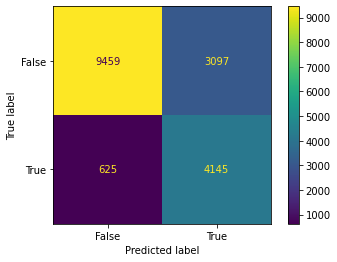

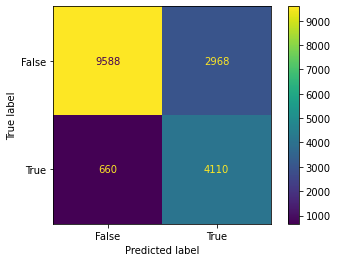

In [ ]:
cm_xgb = metrics.confusion_matrix(y_test, pred_xgb_under)
cm_display_xgb = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_xgb, display_labels = [False, True])

cm_hgbc = metrics.confusion_matrix(y_test, pred_hgbc_under)
cm_display_hgbc = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_hgbc, display_labels = [False, True])

cm_display = [cm_display_xgb,cm_display_hgbc]

plt.figure(figsize=(20,15))

for i in range(0, len(cm_display)):
    cm_display[i].plot()
    plt.show()

### Explainer untuk XGB Undersampling

In [ ]:
#Membuat Explainer untuk Gradient Boosting
canceled_xgb_under_exp = dx.Explainer(xgb_under,x_rus, y_rus, label = "XGBoost Interpretation")

canceled_xgb_under_exp.model_parts().plot()

Preparation of a new explainer is initiated

  -> data              : 38430 rows 37 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 38430 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGBoost Interpretation
  -> predict function  : <function yhat_proba_default at 0x7fb772beeca0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 7.95e-06, mean = 0.5, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.967, mean = -1.69e-05, max = 0.984
  -> model_info        : package xgboost

A new explainer has been created!


In [ ]:
canceled_xgb_under_exp.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 37/37 [00:05<00:00,  6.81it/s]


### Explainer untuk Hist GB Undersampling

In [ ]:
#Membuat Explainer untuk Hist GB
canceled_hgbc_under_exp = dx.Explainer(hgbc_under,x_rus, y_rus, label = "HXGBoost Interpretation")

canceled_hgbc_under_exp.model_parts().plot()

Preparation of a new explainer is initiated

  -> data              : 38430 rows 37 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 38430 values
  -> model_class       : sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier (default)
  -> label             : HXGBoost Interpretation
  -> predict function  : <function yhat_proba_default at 0x7fb772beeca0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.000168, mean = 0.5, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.961, mean = -0.00042, max = 0.994
  -> model_info        : package sklearn

A new explainer has been created!


In [ ]:
canceled_hgbc_under_exp.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


# Deep Dive EDA

## Feature Engineering

#### Menambah kolom `arrival_date` 

sebagai rekap dari `arrival_date_year`, `arrival_date_month`, dan `arrival_date_day_of_month`.

In [ ]:
df['month_number'] = df['arrival_date_month']

In [ ]:
list_bulan = ['January','February','March','April','May','June','July','August','September','October','November','December']
number = ['01','02','03','04','05','06','07','08','09','10','11','12']
df = df.replace({'month_number':{list_bulan[i]: number[i] for i in range(0, len(number))}})

In [ ]:
df['arrival_date'] = df['arrival_date_year'].map(str) + '-' + df['month_number'].map(str) + '-' + df['arrival_date_day_of_month'].map(str)

In [ ]:
df.drop(columns="month_number",inplace=True)

In [ ]:
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

#### Membuat kolom `Total_Guests` 

dilihat dari jumlah `adults`, `childern` dan `Babies`

In [ ]:
# Calculating total guests for each record
df['Total_Guests'] = df['adults'] + df['children'] + df['babies']

#### Membuat kolom `Total_Stays` 

dilihat dari jumlah `stays_in_weekend_nights` dan `stays_in_week_nights`.

In [ ]:
df['Total_Stays'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

#### Membuat kolom `is_room_changes?`

In [ ]:
df['is_room_changes'] = np.where(df['reserved_room_type'] == df['assigned_room_type'], 0, 1) #create a new column in df1 to check if prices match

In [ ]:
df.sample(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,Total_Guests,Total_Stays,is_room_changes
44584,City Hotel,0,71,2015,October,41,8,1,3,2,0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,D,0,No Deposit,9,0,Contract,90.56,0,1,Check-Out,2015-10-12,2015-10-08,2,4,1
10527,Resort Hotel,1,30,2017,March,11,12,1,0,1,0,0,BB,PRT,Corporate,Direct,0,0,0,A,D,0,No Deposit,87,0,Transient-Party,48.00,0,0,Canceled,2017-03-10,2017-03-12,1,1,1


## Deep Dive Question

In [ ]:
#Untuk data pemesan yang berhasil menginap
checkout = df[df["reservation_status"]=="Check-Out"]

#### Hotel mana yang persentase cancelnya lebih besar?

In [ ]:
resort = df[df['hotel']=='Resort Hotel']
city = df[df['hotel']=='City Hotel']

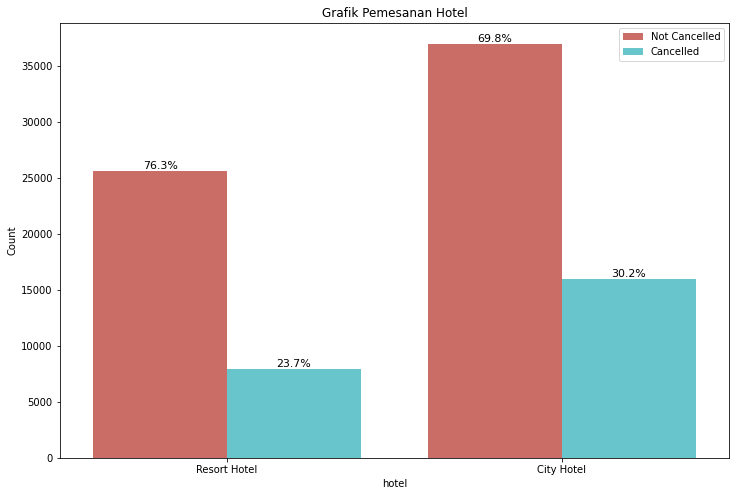

In [ ]:
def percentage_above_bar_relative_to_xgroup(ax):
    all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
    for bars in ax.containers:
        for i, p in enumerate(bars):
            total = sum(xgroup[i] for xgroup in all_heights)
            percentage = f'{(100 * p.get_height() / total) :.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=11, ha='center', va='bottom')


plt.figure(figsize=(12, 8))
ax3 = sns.countplot(x="hotel",data=df,hue="is_canceled",palette="hls")
ax3.set(xlabel='hotel', ylabel='Count')

plt.title('Grafik Pemesanan Hotel')
plt.legend(['Not Cancelled', 'Cancelled'])
percentage_above_bar_relative_to_xgroup(ax3)
plt.show()

In [ ]:
df.groupby(['hotel','is_canceled']).agg(total = ('hotel','count')).sort_values('is_canceled',ascending=False)

,,total
hotel,is_canceled,
City Hotel,1,16021
Resort Hotel,1,7964
City Hotel,0,37017
Resort Hotel,0,25626


JAWABAN :

Walaupun City Hotel lebih banyak melakukan pemesanan dan checkout, tetapi cancelnya juga lebih besar daripada Resort Hotel. Jadi City Hotel belum tentu lebih stabil ketimbang Resort Hotel.

#### Kapan bookingan paling ramai?

In [ ]:
list_bulan = ['January','February','March','April','May','June','July','August','September','October','November','December']
df_sort_month = df.copy()
df_sort_month['arrival_date_month'] = pd.Categorical(df_sort_month['arrival_date_month'], categories=list_bulan, ordered=True)

In [ ]:
month = df_sort_month.groupby(['arrival_date_year','arrival_date_month']).agg(jumlah_pengunjung = ('hotel','count')).reset_index()
month = month.drop(labels=[0,1,2,3,4,5,32,33,34,35], axis=0)
month.sort_values('jumlah_pengunjung',ascending=False)

,arrival_date_year,arrival_date_month,jumlah_pengunjung
28,2017,May,4556
30,2017,July,4517
19,2016,August,4394
31,2017,August,4372
29,2017,June,4234
21,2016,October,4181
27,2017,April,4129
20,2016,September,3835
18,2016,July,3818
14,2016,March,3791


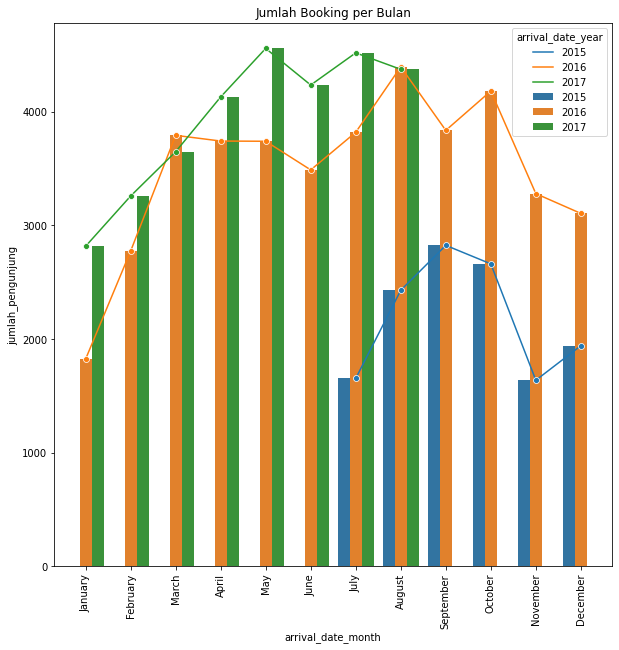

In [ ]:
plt.figure(figsize=(10,10))
plt.xticks(rotation=90)
plt.title('Jumlah Booking per Bulan')
sns.barplot(data=month, x='arrival_date_month', y='jumlah_pengunjung', hue = 'arrival_date_year')
sns.lineplot(data=month, x='arrival_date_month', y='jumlah_pengunjung', hue = 'arrival_date_year', marker = "o", palette = "tab10")
plt.show()

JAWABAN :

May 2017 menempati jumlah booking paling tinggi. Secara garis besar, pola booking-an dalam setahun terbagi menjadi dua termin dan membentuk distribusi normal tiap terminnya. Pada awal, tengah, dan akhir tahun cenderung rendah. Tetapi memuncak pada 2/5 dan 4/5 tahun.

Catatan : Ada penurunan signifikan pada bulan oktober ke november di tahun 2015 yang tidak seperti biasanya. Penurunan drastis kedua pun terjadi dibulan yang sama di tahun selanjutnya.

#### Berapa paling lama rencana pengunjung menginap di tiap hotelnya? Dan dari negara mana kah dia?

In [ ]:
df.groupby(['hotel','country']).agg(lama_menginap = ('Total_Stays','max')).sort_values('lama_menginap',ascending=False).head(5)

lama_menginap
hotel        country                 
Resort Hotel Undefined             69
             PRT                   56
             GBR                   56
City Hotel   PRT                   48
Resort Hotel ESP                   46

JAWABAN :

Dari Resort hotel, rencana menginap paling lama yaitu 69 hari namun data negara dikosongkan. Kemudian posisi kedua yaitu dari warga lokal yaitu Portugis sebanyak 56 hari.

Begitupun dengan City Hotel didominasi oleh warga lokal sebanyak 48 hari.

#### Berapa jumlah paling banyak dan rata-rata pengunjung tiap booking?

In [ ]:
df.groupby(['hotel']).agg({'Total_Guests':['mean','max']})

Total_Guests    
                     mean max
hotel                        
City Hotel       2.022267   5
Resort Hotel     2.043555  55

JAWABAN :

Jumlah pengunjung di kedua hotel rata-rata adalah 2 orang. Adapun untuk maksimum pengunjung per pemesanan adalah 5 untuk City Hotel dan 55 untuk Resort Hotel. Artinya City Hotel tidak pernah menerima pelanggan dalam jumlah besar, kemungkinan hanya family dan bussiness trip saja. Sedangkan Resort Hotel kemungkinan lebih sering menerima group.

#### Berapa jumlah parkiran yang diperlukan agar pihak hotel dapat selalu memenuhi keinginan customernya?

In [ ]:
df.groupby(['hotel','arrival_date']).agg(jumlah_mobil = ('required_car_parking_spaces','sum')).sort_values('jumlah_mobil',ascending=False).head(3)

,,jumlah_mobil
hotel,arrival_date,
Resort Hotel,2016-06-25,22
City Hotel,2016-03-24,20
Resort Hotel,2017-04-29,20


JAWABAN :

Untuk Resort Hotel yaitu sebanyak 22 mobil. Adapun City Hotel 20 mobil.

*Diasumsikan tiap pengunjung hanya menyimpan mobil di hari pertama atau hanya menginap satu hari. Sehingga baiknya pihak hotel memberikan lebih dari data tertera.

#### **Negara mana yang memiliki rencana menginap paling lama di tiap hotel?**

In [ ]:
lama_menginap_resort = resort.groupby(['country']).agg(lama_menginap = ('Total_Stays','max')).sort_values('lama_menginap',ascending=False).reset_index()
lama_menginap_city = city.groupby(['country']).agg(lama_menginap = ('Total_Stays','max')).sort_values('lama_menginap',ascending=False).reset_index()

In [ ]:
def show_count(plot):
  for p in plot.patches:
    y = p.get_y() +p.get_height() / 2
    x = p.get_width()+2
    plot.annotate(p.get_width(), (x, y), ha='center', va='center')

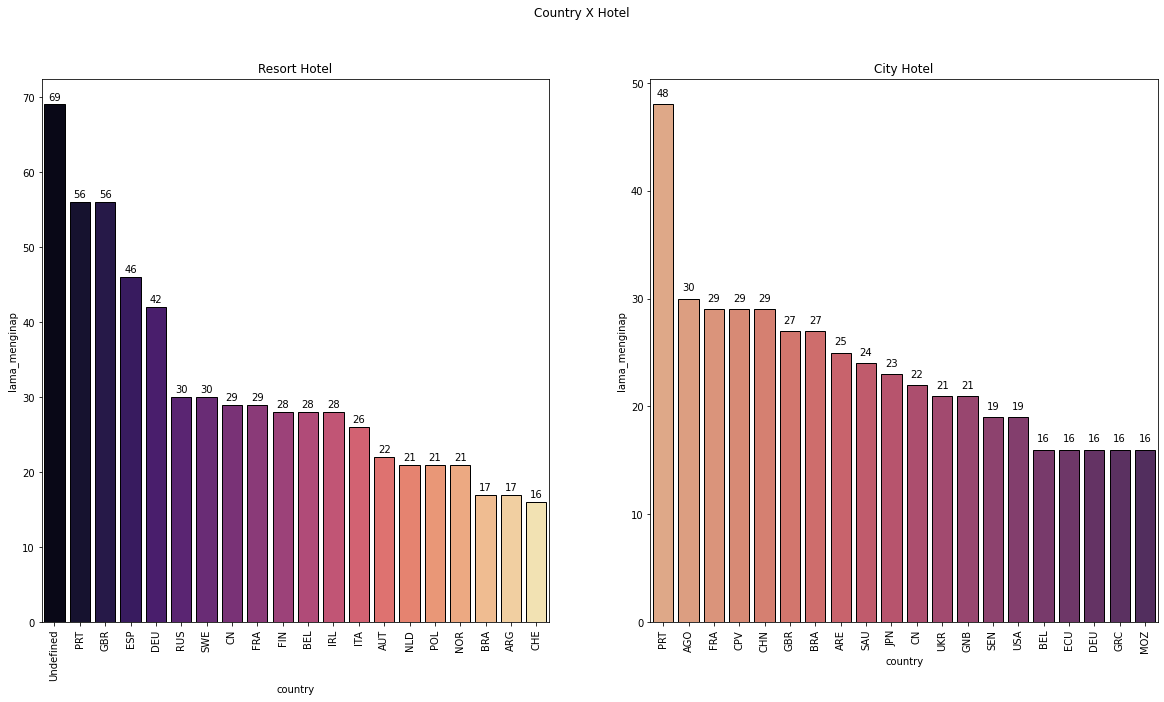

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
ax = sns.barplot(x=lama_menginap_resort["country"][:20],y=lama_menginap_resort["lama_menginap"],data=lama_menginap_resort,palette="magma",edgecolor="black")
for p in ax.patches:
    x = p.get_x() +p.get_width() / 2
    y = p.get_height()+1
    ax.annotate(str(int(p.get_height())), (x, y), ha='center', va='center')
plt.xticks(rotation=90)
plt.title('Resort Hotel')

plt.subplot(1, 2, 2)
ax2 = sns.barplot(x=lama_menginap_city["country"][:20],y=lama_menginap_city["lama_menginap"],data=lama_menginap_city,palette="flare",edgecolor="black")
for p in ax2.patches:
    x = p.get_x() +p.get_width() / 2
    y = p.get_height()+1
    ax2.annotate(str(int(p.get_height())), (x, y), ha='center', va='center')
plt.xticks(rotation=90)
plt.title('City Hotel')

plt.suptitle("Country X Hotel")
plt.show()

#### **Berapa lama pengunjung paling sering menginap?**

In [ ]:
stays=df[["hotel","Total_Stays"]].value_counts().to_frame().reset_index()
stays.sort_values(0,ascending=False).head(10)

,hotel,Total_Stays,0
0,City Hotel,3,13541
1,City Hotel,2,10812
2,City Hotel,1,10267
3,City Hotel,4,9610
4,Resort Hotel,1,6894
5,Resort Hotel,7,5675
6,Resort Hotel,2,4921
7,Resort Hotel,3,4285
8,City Hotel,5,4168
9,Resort Hotel,4,3955


In [ ]:
stays_resort=resort[["Total_Stays"]].value_counts().to_frame().reset_index()
stays_city=city[["Total_Stays"]].value_counts().to_frame().reset_index()

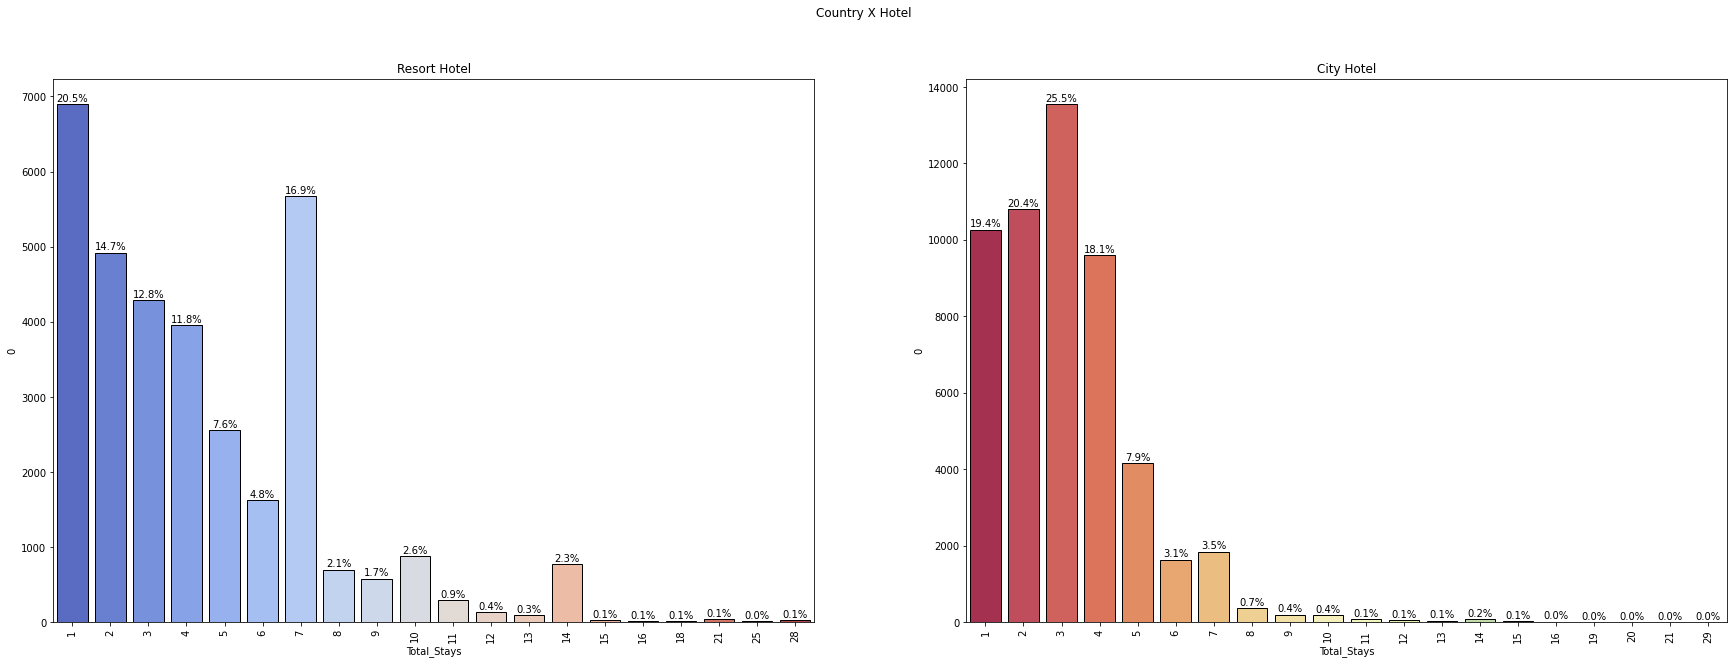

In [ ]:
plt.figure(figsize=(30,10))

plt.subplot(1, 2, 1)
ax = sns.barplot(x=stays_resort["Total_Stays"][:20],y=stays_resort[0],data=stays_resort,palette="coolwarm",edgecolor="black")
total = len(resort)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.xticks(rotation=90)
plt.title('Resort Hotel')

plt.subplot(1, 2, 2)
ax = sns.barplot(x=stays_city["Total_Stays"][:20],y=stays_city[0],data=stays_city,palette="Spectral",edgecolor="black")
total = len(city)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.xticks(rotation=90)
plt.title('City Hotel')

plt.suptitle("Country X Hotel")
plt.show()

In [ ]:
stays=df[["hotel","Total_Stays"]].value_counts().to_frame().reset_index()

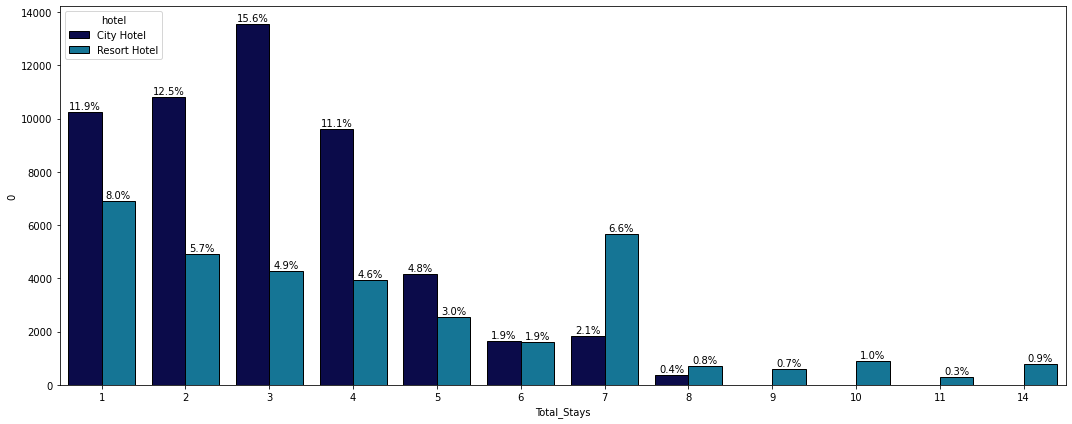

In [ ]:
plt.figure(figsize=(15,6))
ax = sns.barplot(x=stays["Total_Stays"][:20],y=stays[0],data=stays,hue="hotel",palette="ocean",edgecolor="black")
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

JAWABAN :

City Hotel kebanyakan diinapi 3 hari atau rentang 1-4 hari . Sedangkan Resort Hotel kebanyakan diinapi 1 atau 7 hari, selebihnya 2-4 hari.